<a href="https://colab.research.google.com/github/DerWeiseTeufel/Tinkoff_Risk_Analytics_2024/blob/main/Khamazaev_clo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Управление рисками 2024. Домашнее задание №3.

*Дата выдачи: 10.04.2024*

*Дедлайн: 24.04.2024, 23:59*

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Привет!

В данном домашнем задании тебе предстоит построить кривые def rate и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score и PD (**data_scores.csv**). Не бойся выходить за рамки методов, предложенных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям.

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **10 баллов**. Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматься в случае неполного выполнения задания или отсутствия аргументации.


#### Задачи:

1) Построить кривые DEF rate (5 баллов)
    - Выбрать переменную для разбивки по бакетам (0.5 балла)
    - Провести анализ поколений (0.5 балла)
    - Построить винтажи CLO rate (0.5 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Провести анализ наличия внешних воздействий и при необходимости вычистить кривые (2 балла)
    - Построить среднее по винтажам для каждого бакета (0.5 балла)
    - Сгладить кривые (0.5 балла)
    
2) Построить кривые CLO rate (5 баллов)
    - Пункты, аналогчные DEF rate
    
**Пожалуйста, аргументируйте свои решения по каждому пункту**

В качестве результата по пунктам 2 и 3 приложите текущий ноутбук с названием 'Surname_clo.ipynb'

## Кривые CLO rate

#### Выгружаем данные с винтажами

# load dataset from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
def load_dataset(path_from, path_to = "/content/"):
  with ZipFile(path_from) as zipref:
    zipref.extractall(path_to)

In [ ]:
path = "/content/drive/MyDrive/Tinkoff/HW_3_data.zip"
load_dataset(path)

In [ ]:
path_data_score = "/content/data_scores.csv"
path_data_vintages = "/content/data_vintages.csv"

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score


In [ ]:
df = pd.read_csv(path_data_vintages,
                  sep=';',
                  encoding="cp1251",
                  index_col=0,
                  date_parser=lambda x: pd.to_datetime(x), #преобразуем даты
                  parse_dates=['gen_month_dt', 'gen_quarter_dt']
                  )
df.head()

<ipython-input-7-865536430a6d>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path_data_vintages,


user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01        0        0   
1    35907             16   2019-04-01     2019-04-01        1        0   
2    45228             21   2019-05-01     2019-04-01        0        0   
3    39035             23   2019-07-01     2019-07-01        0        0   
4   130780             19   2019-08-01     2019-07-01        1        0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  
0        0        1             0             0             0             1  
1        0        0             1             0             0             0  
2        0        1             0             0             0             1  
3        0        1             0             0             0             1  
4        0        0             1             0             0             0

#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [ ]:
df_scores = pd.read_csv(path_data_score,
                        sep=';',
                        encoding="cp1251",
                        decimal=',',
                        index_col=0
                        )
df_scores.head()

user_id        pd   x_score
0     9311  0.035025  0.219980
1   155026  0.046279  0.146986
2    17584  0.007221  0.343298
3   156231  0.069679  0.186684
4   123587  0.010402  0.305582

#### Бъем выборку на бакеты и джойним с данными с винтажами

Разбиение на 3 бакета

In [ ]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01        0        0   
1    35907             16   2019-04-01     2019-04-01        1        0   
2    45228             21   2019-05-01     2019-04-01        0        0   
3    39035             23   2019-07-01     2019-07-01        0        0   
4   130780             19   2019-08-01     2019-07-01        1        0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  \
0        0        1             0             0             0             1   
1        0        0             1             0             0             0   
2        0        1             0             0             0             1   
3        0        1             0             0             0             1   
4        0        0             1             0             0             0   

   pd_bucket  x_bucket        pd   x_score  
0          1         2  0.021296  0.469410  
1          2         0  0.064742  0.157215  
2          0         2  0.018490  0.469583  
3          1         1  0.025882  0.210896  
4          1         1  0.024330  0.269492

### Выбери переменную, которая делит кривые наилучшим образом (0.5 баллов)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

$$CLOSEDrate_n = \frac{\#CLO_n - \#CLO_{n-1}}{\#ACT_{n-1}}$$

In [ ]:
df.head()

user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0   127336             19   2019-07-01     2019-07-01        0        0   
1    35907             16   2019-04-01     2019-04-01        1        0   
2    45228             21   2019-05-01     2019-04-01        0        0   
3    39035             23   2019-07-01     2019-07-01        0        0   
4   130780             19   2019-08-01     2019-07-01        1        0   

   dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  prev_act_flg  \
0        0        1             0             0             0             1   
1        0        0             1             0             0             0   
2        0        1             0             0             0             1   
3        0        1             0             0             0             1   
4        0        0             1             0             0             0   

   pd_bucket  x_bucket        pd   x_score  
0          1         2  0.021296  0.469410  
1          2         0  0.064742  0.157215  
2          0         2  0.018490  0.469583  
3          1         1  0.025882  0.210896  
4          1         1  0.024330  0.269492

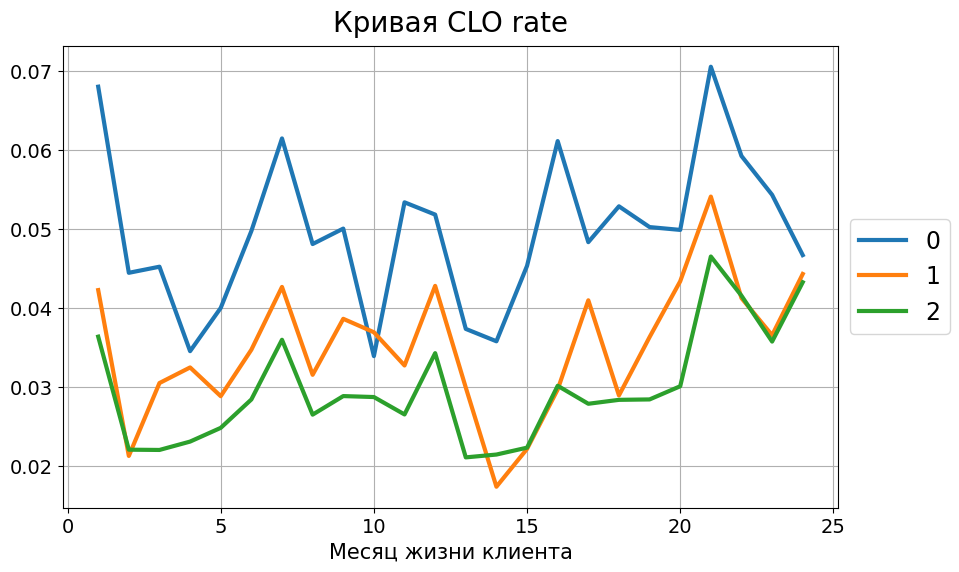

In [ ]:
def plot_clo_rate_by_bucket(df, bucket):
    return (df.query(''' gen_month_dt == '2019-04-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.sum, "prev_act_flg":np.sum, "prev_clo_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"clo_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt',"prev_clo_flg":'prev_clo_cnt',  "user_id":"cnt"}))\
            .eval('clo_rate = (clo_cnt - prev_clo_cnt)/ prev_act_cnt', inplace=False)\
            .unstack(bucket)
            ['clo_rate']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_clo_rate_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

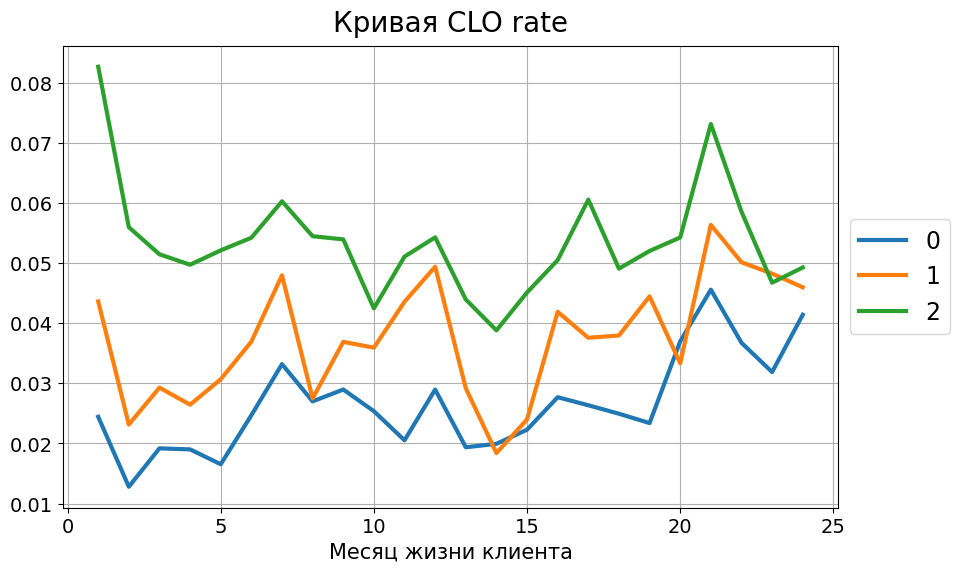

In [ ]:
plot_clo_rate_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: x_score лучше разделяет кривые

### Анализ поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

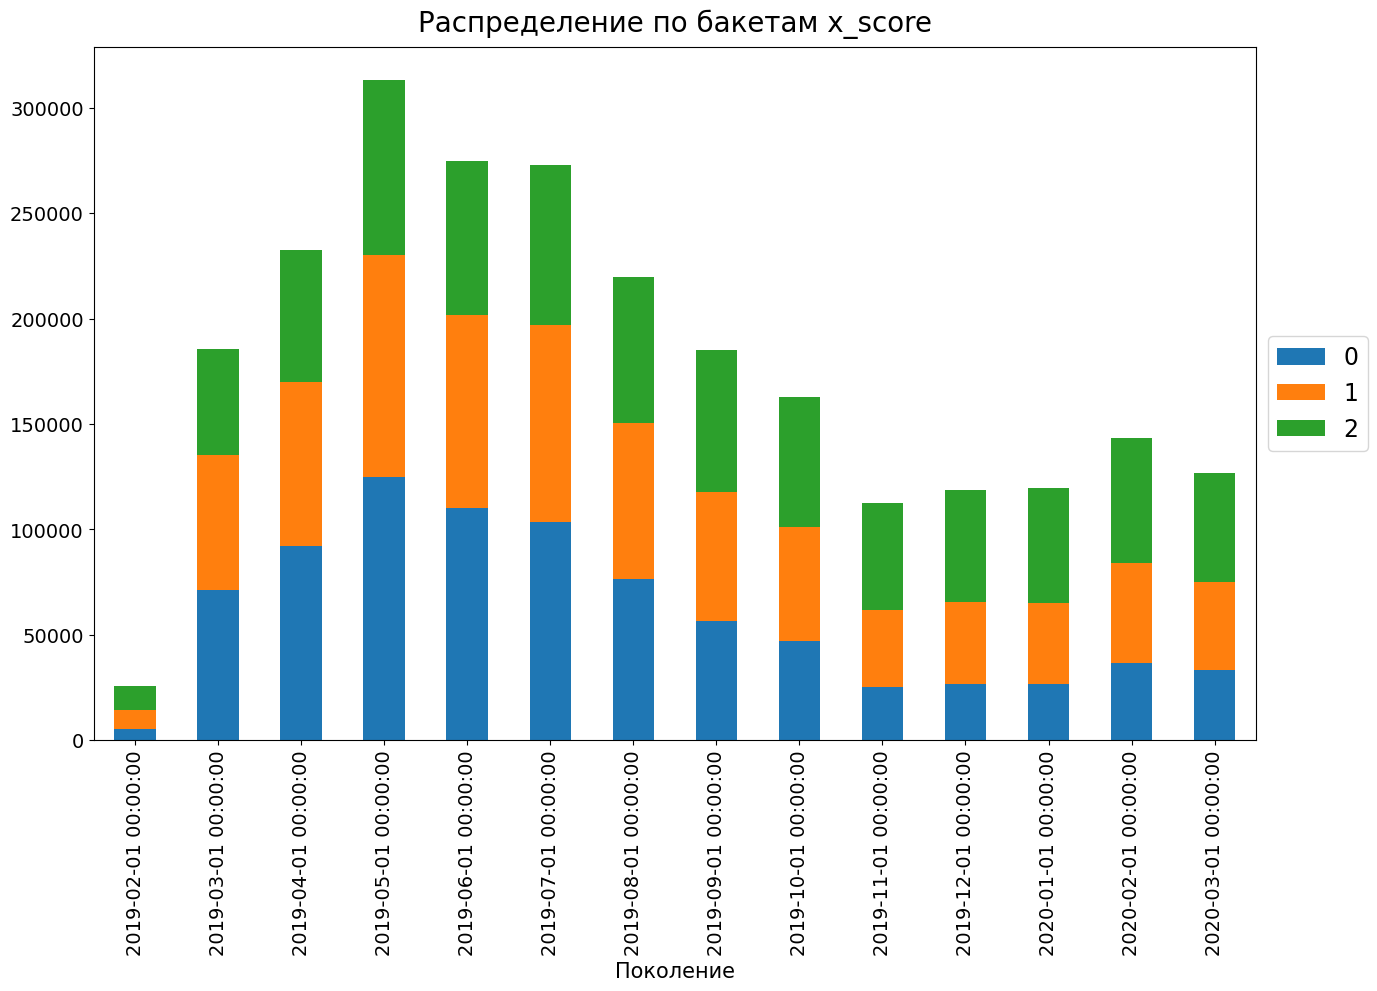

In [ ]:
def plot_distribution(df, bucket):
  return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам x_score", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)


#### Вывод: поколение 2019-02-01 содержит подозрительно мало данных, я считаю его нерепрезентативным, предлагаю его удалить

### Кривые СLO Rate в разбивке по бакетам (0.5 баллов)

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

#### По бакетам

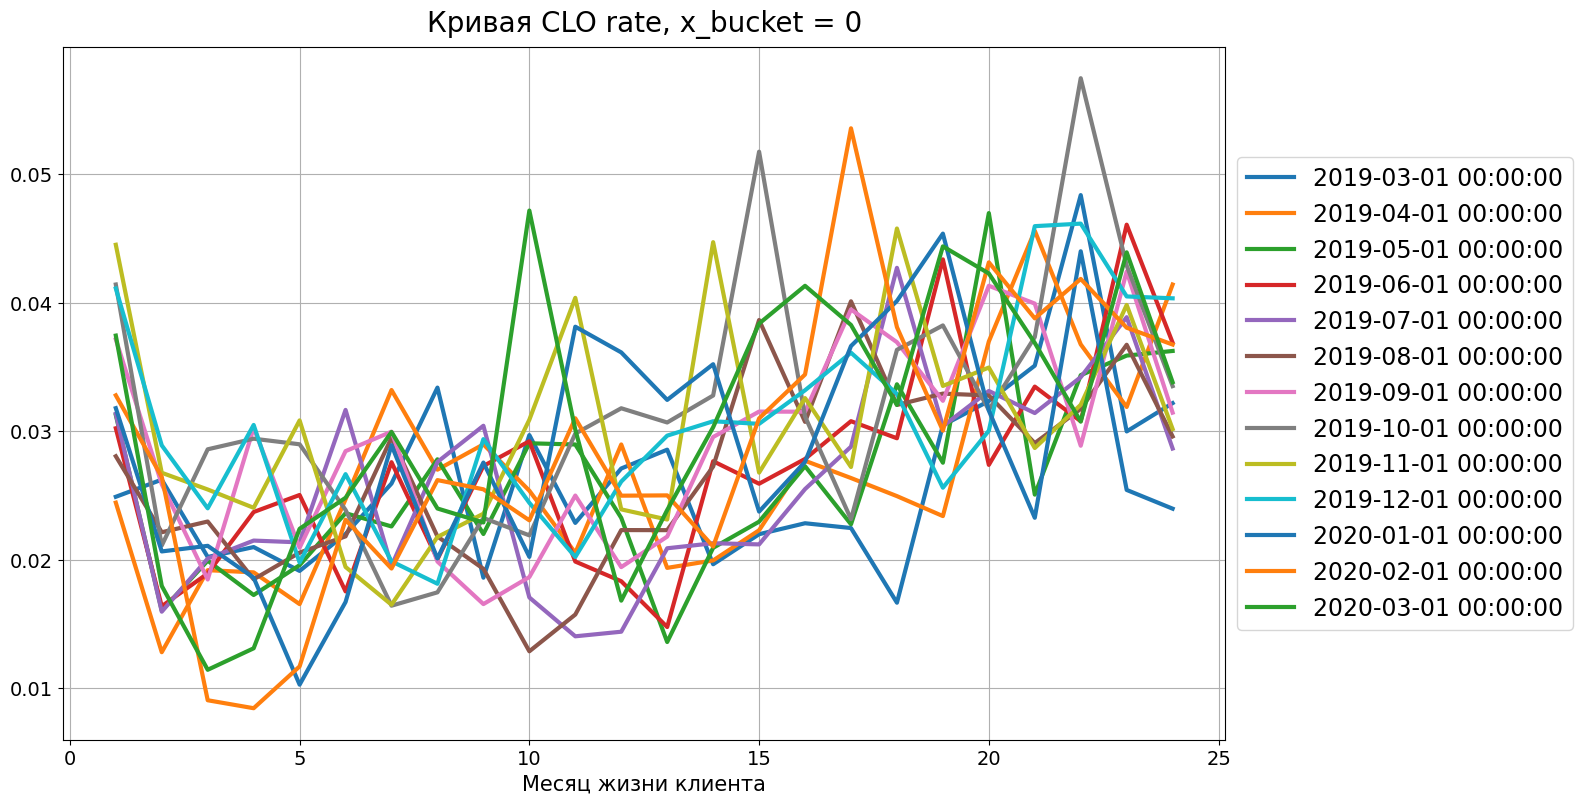

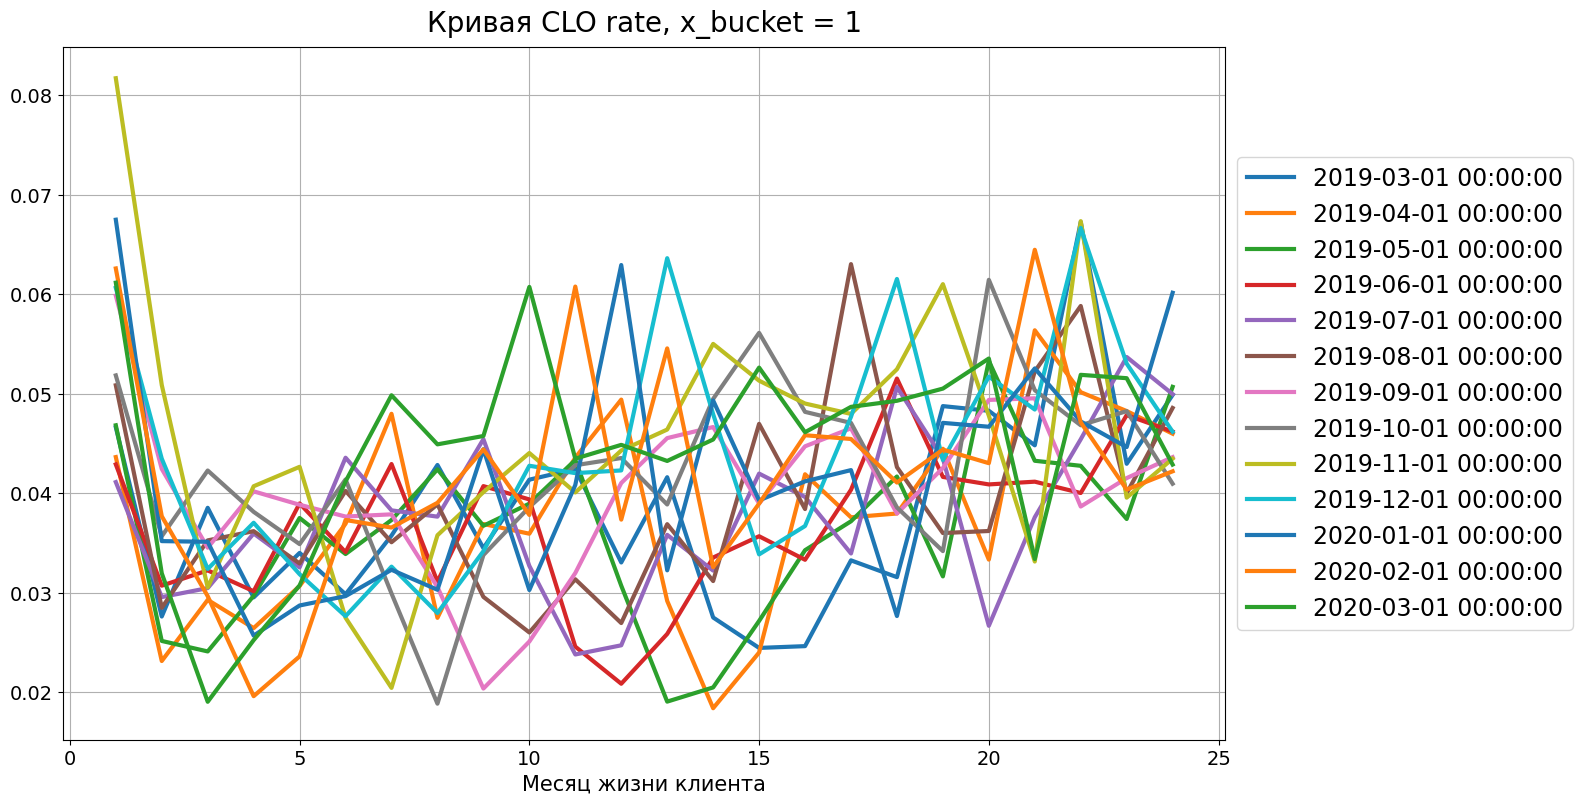

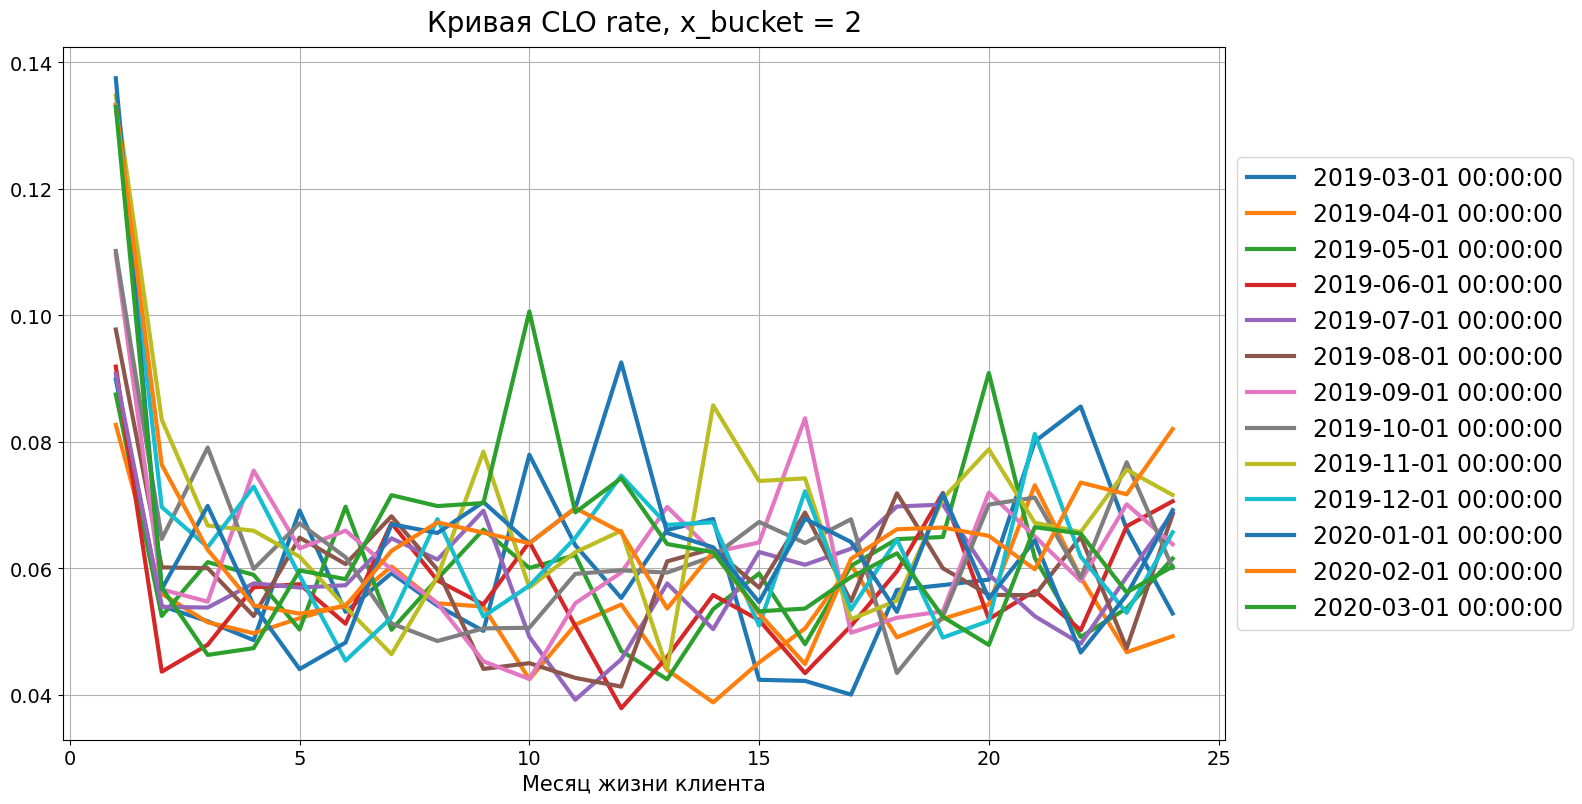

In [ ]:
# Исключаем плохое поколение

exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

# Делаем список бакетов

buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_clo_rate_by_generation(data, x_bucket):
    data_tmp = data.query(''' x_bucket == @x_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
            .agg({"clo_flg":np.sum, "prev_act_flg":np.sum, "prev_clo_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"clo_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt',"prev_clo_flg":'prev_clo_cnt',  "user_id":"cnt"}))\
            .eval('clo_rate = (clo_cnt - prev_clo_cnt)/ prev_act_cnt', inplace=False)\
        .unstack('gen_month_dt')['clo_rate']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)


for i in buckets:
    plot_clo_rate_by_generation(df, i)


In [ ]:
mask = (df['gen_month_dt'] > '2019-03-01') & (df['gen_month_dt'] <= '2019-08-01')
df.loc[mask]

user_id  statement_num gen_month_dt gen_quarter_dt  clo_flg  def_flg  \
0         127336             19   2019-07-01     2019-07-01        0        0   
1          35907             16   2019-04-01     2019-04-01        1        0   
2          45228             21   2019-05-01     2019-04-01        0        0   
3          39035             23   2019-07-01     2019-07-01        0        0   
4         130780             19   2019-08-01     2019-07-01        1        0   
...          ...            ...          ...            ...      ...      ...   
2493258   118959              7   2019-08-01     2019-07-01        0        0   
2493260   111683             23   2019-07-01     2019-07-01        1        0   
2493263    64006             19   2019-05-01     2019-04-01        1        0   
2493265   120568              1   2019-08-01     2019-07-01        0        0   
2493267    64790             17   2019-06-01     2019-04-01        0        0   

         dlq_flg  act_flg  prev_clo_flg  prev_def_flg  prev_dlq_flg  \
0              0        1             0             0             0   
1              0        0             1             0             0   
2              0        1             0             0             0   
3              0        1             0             0             0   
4              0        0             1             0             0   
...          ...      ...           ...           ...           ...   
2493258        0        1             0             0             0   
2493260        0        0             1             0             0   
2493263        0        0             0             0             1   
2493265        0        1             0             0             0   
2493267        0        1             0             0             0   

         prev_act_flg  pd_bucket  x_bucket        pd   x_score  
0                   1          1         2  0.021296  0.469410  
1                   0          2         0  0.064742  0.157215  
2                   1          0         2  0.018490  0.469583  
3                   1          1         1  0.025882  0.210896  
4                   0          1         1  0.024330  0.269492  
...               ...        ...       ...       ...       ...  
2493258             1          1         0  0.030678  0.094264  
2493260             0          0         2  0.002997  0.469441  
2493263             1          2         1  0.052035  0.188233  
2493265             1          2         0  0.059505  0.104274  
2493267             1          1         0  0.023601  0.167916  

[1313133 rows x 16 columns]

#### По бакетам первая половина

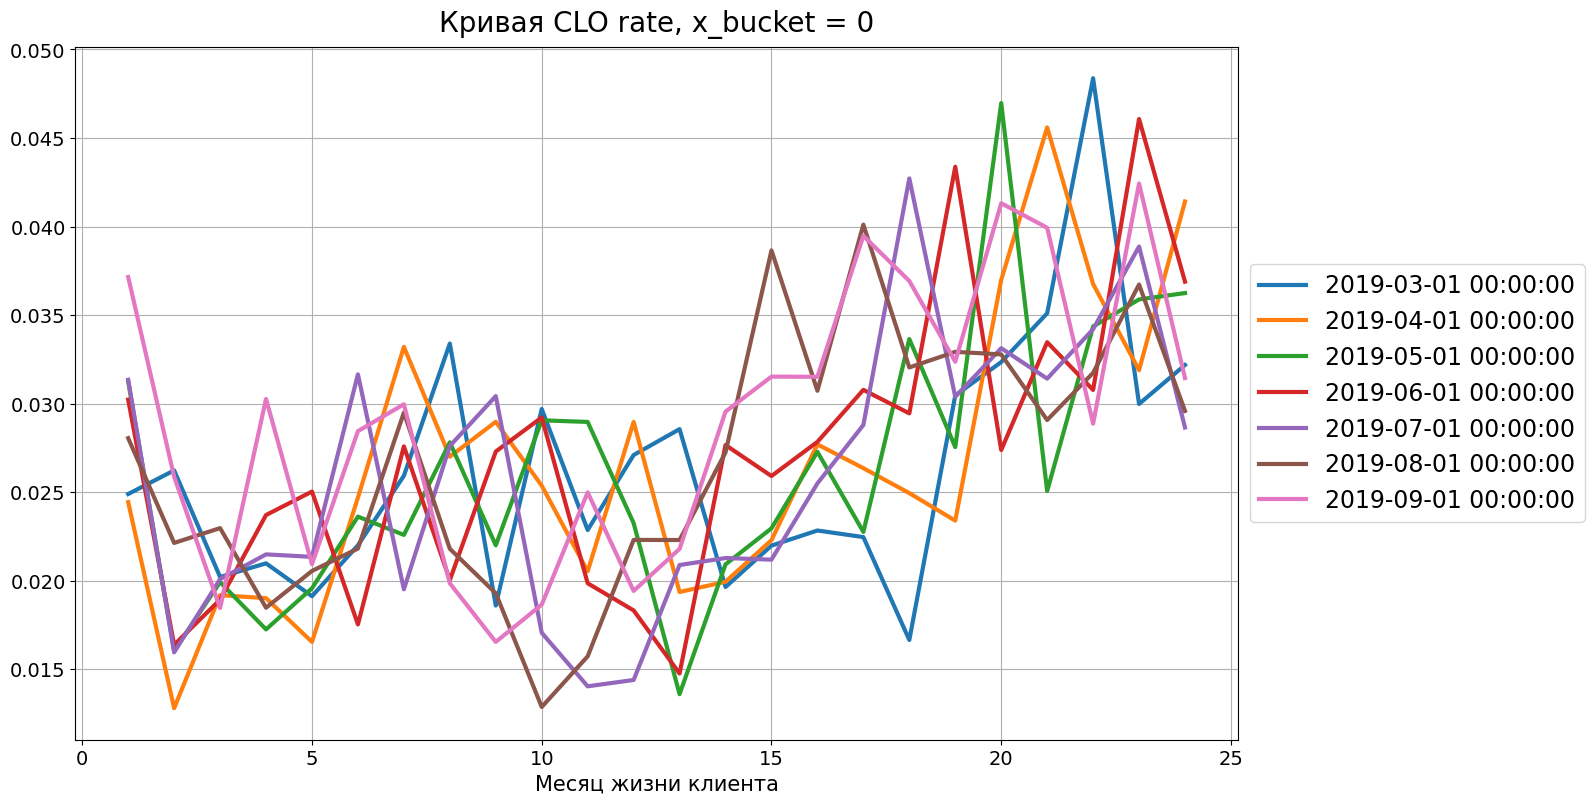

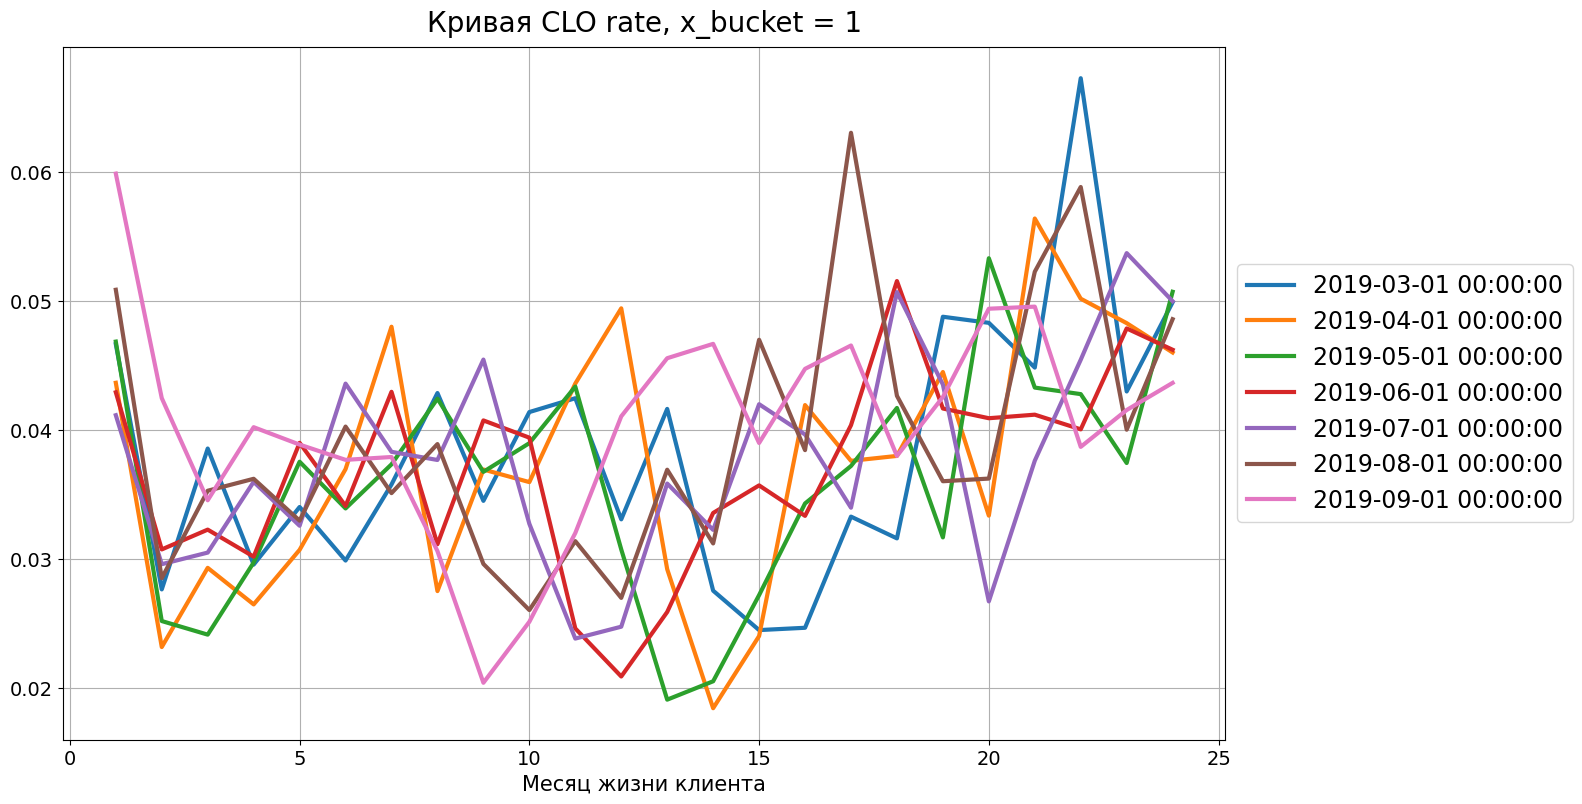

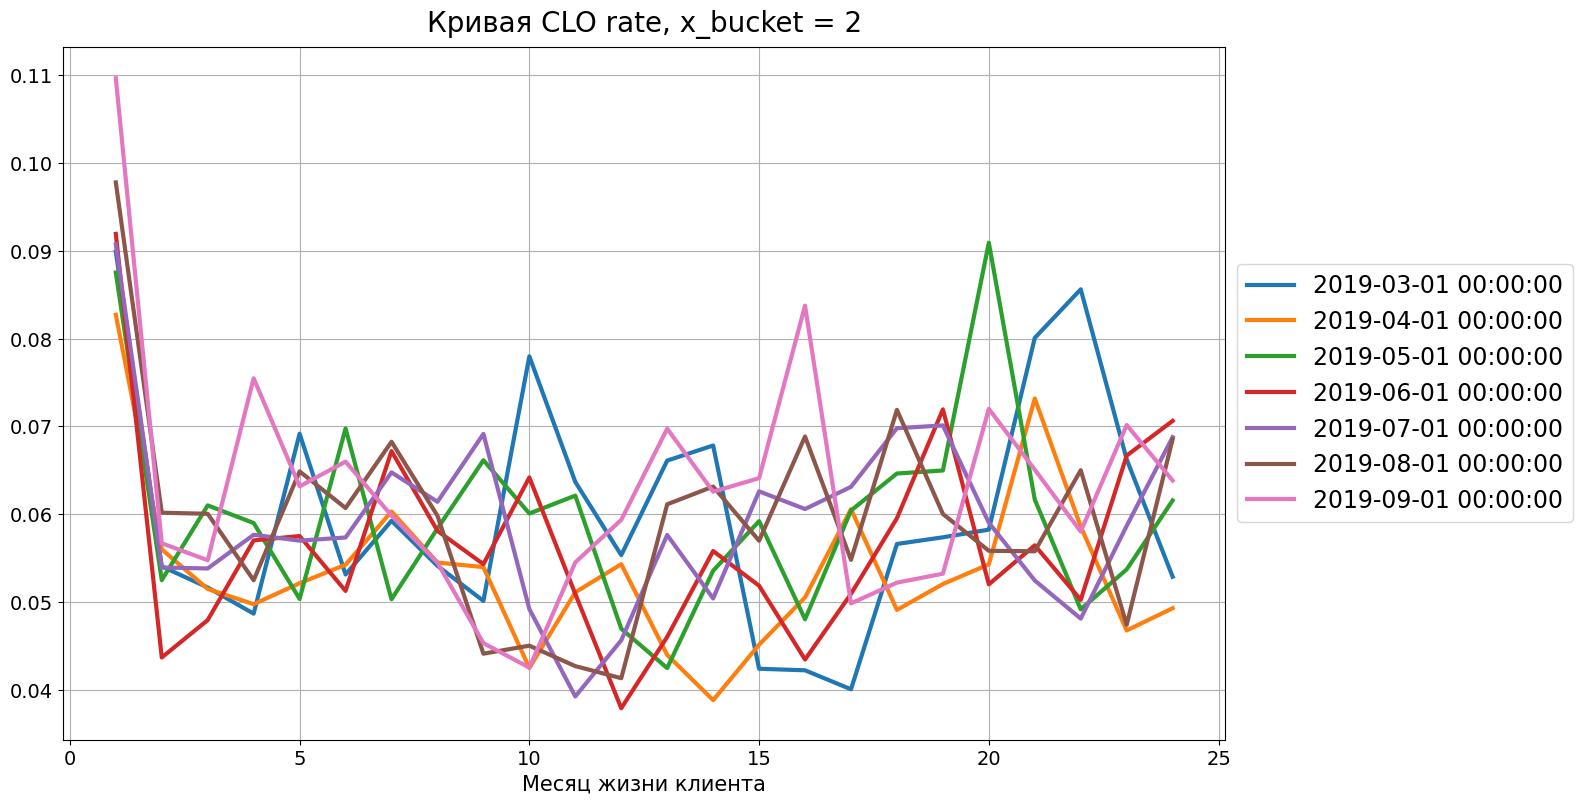

In [ ]:

buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_clo_rate_by_generation_range(data, x_bucket, gen_start, gen_end):
    mask = (data['gen_month_dt'] > gen_start) & (data['gen_month_dt'] <= gen_end)
    data = data.loc[mask]
    data_tmp = data.query(''' x_bucket == @x_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
            .agg({"clo_flg":np.sum, "prev_act_flg":np.sum, "prev_clo_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"clo_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt',"prev_clo_flg":'prev_clo_cnt',  "user_id":"cnt"}))\
            .eval('clo_rate = (clo_cnt - prev_clo_cnt)/ prev_act_cnt', inplace=False)\
        .unstack('gen_month_dt')['clo_rate']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

gen_start= '2019-01-01'
gen_end = '2019-09-01'
for i in buckets:
    plot_clo_rate_by_generation_range(df, i, gen_start, gen_end)

#### по бакетам вторая половина

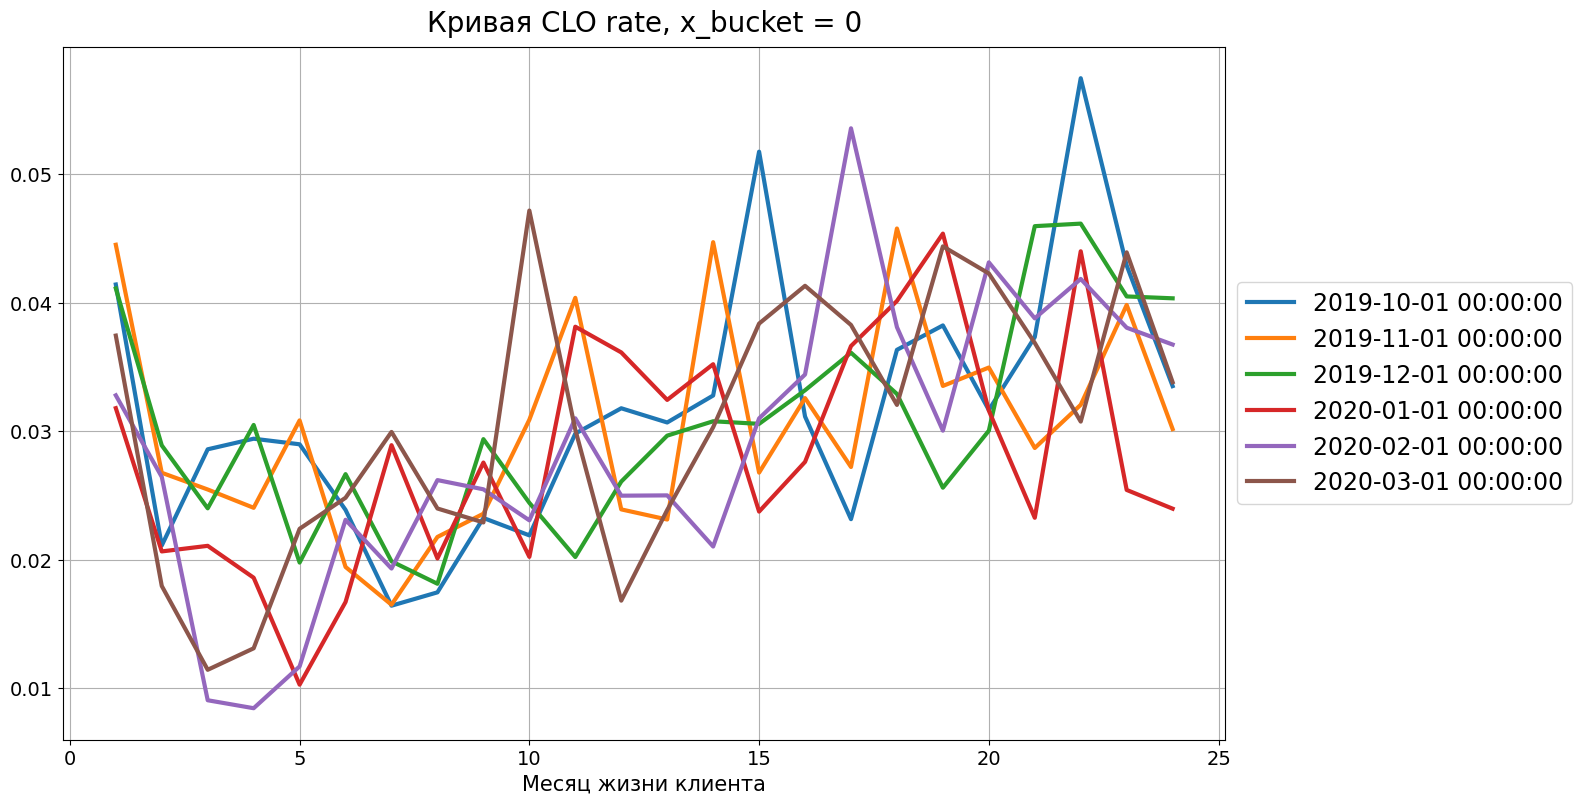

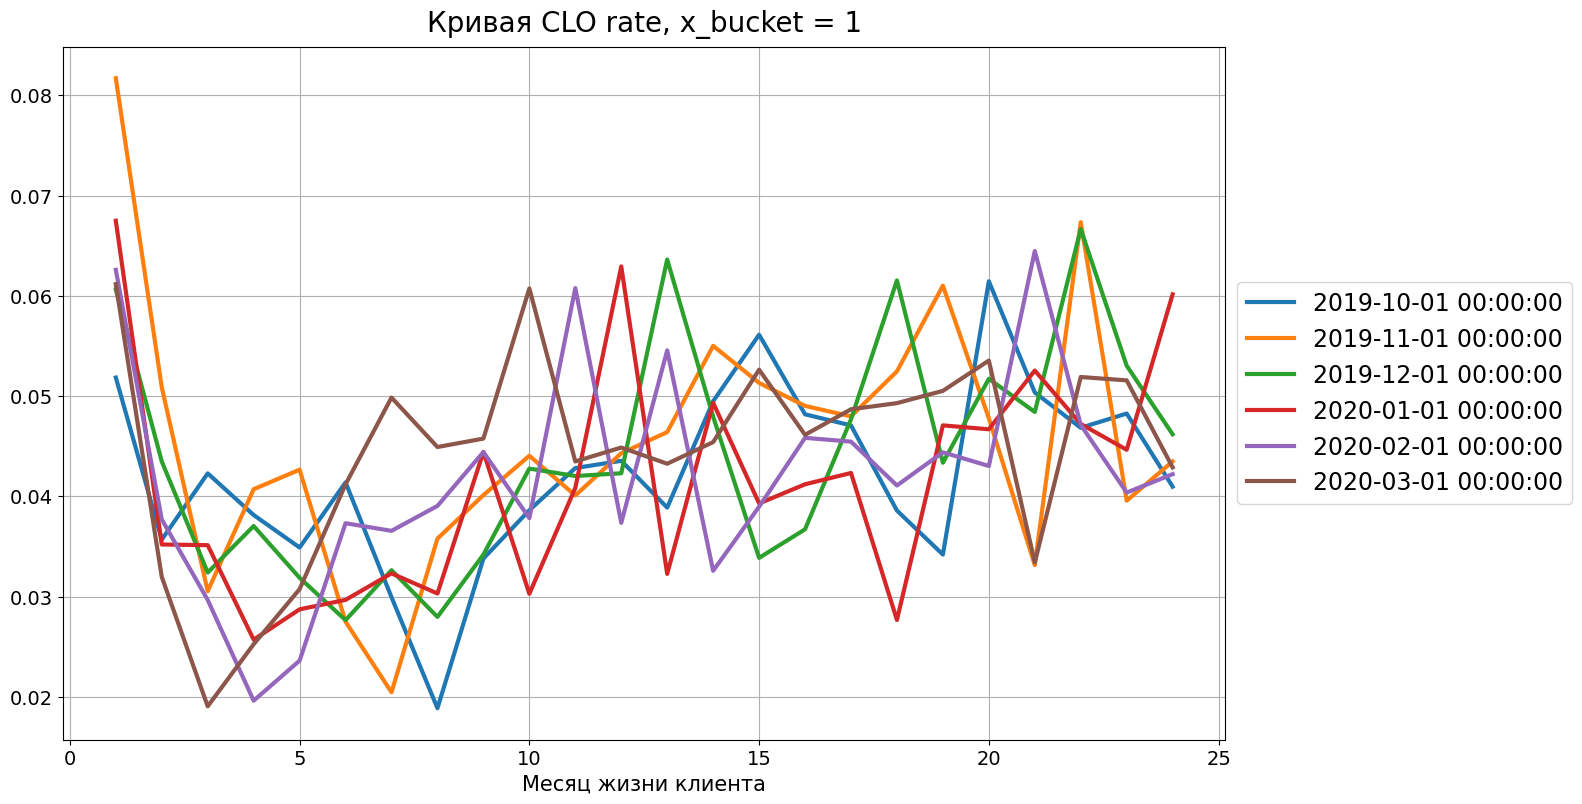

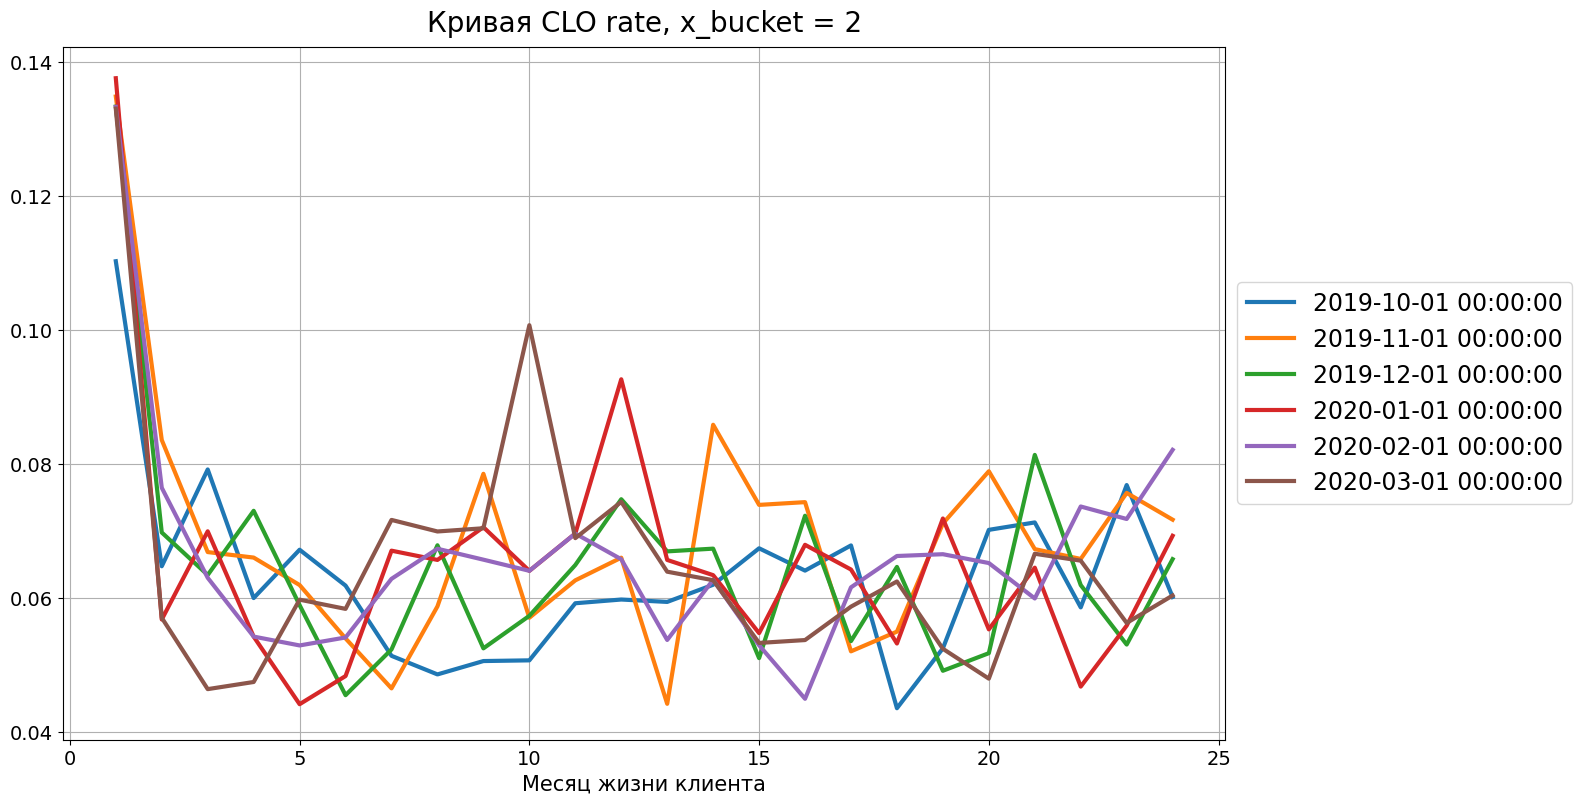

In [ ]:

buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета


gen_start= '2019-09-01'
gen_end = '2020-03-01'
for i in buckets:
    plot_clo_rate_by_generation_range(df, i, gen_start, gen_end)

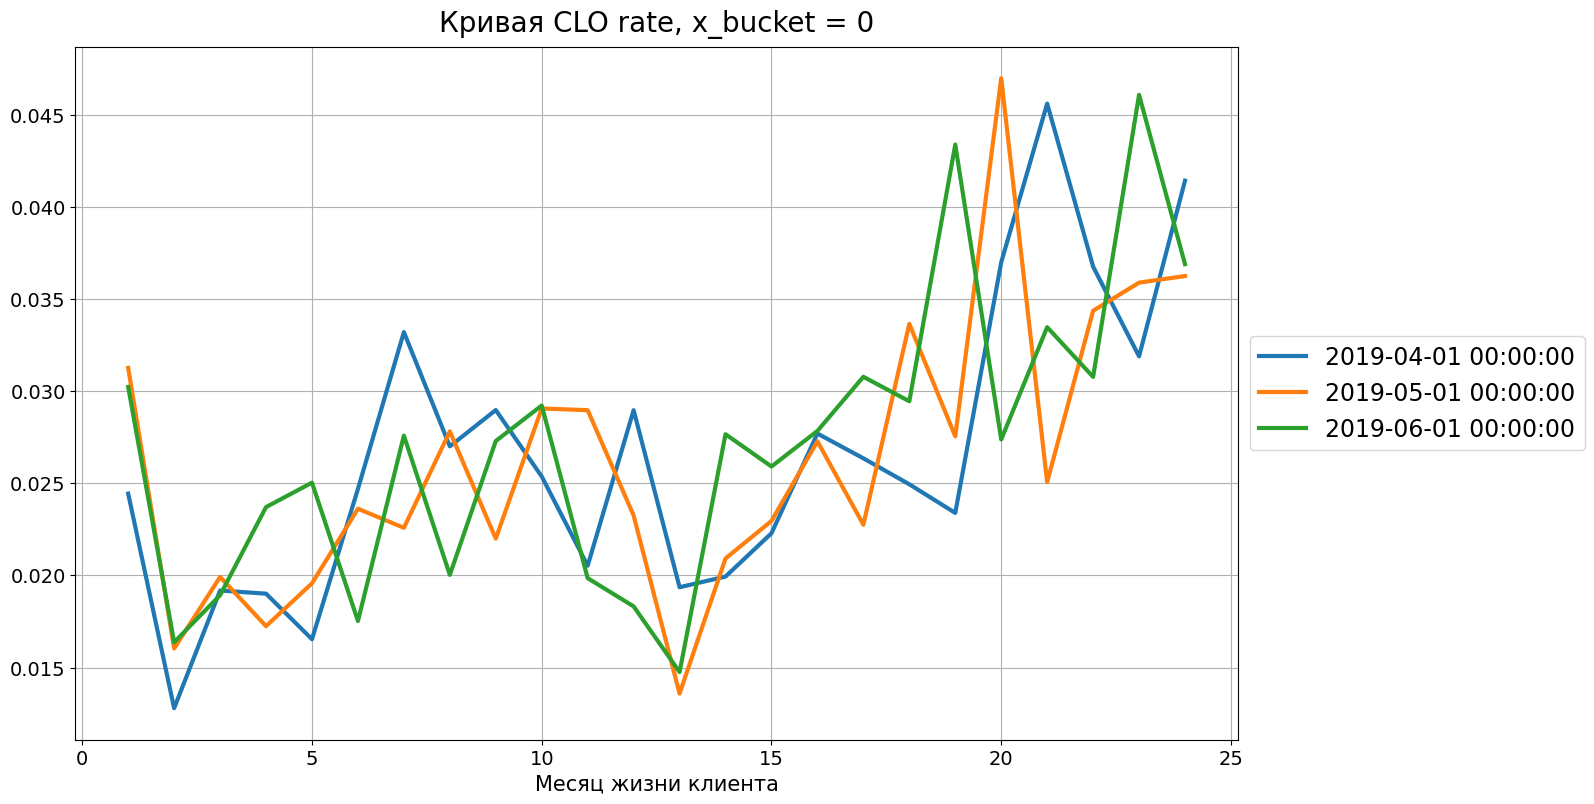

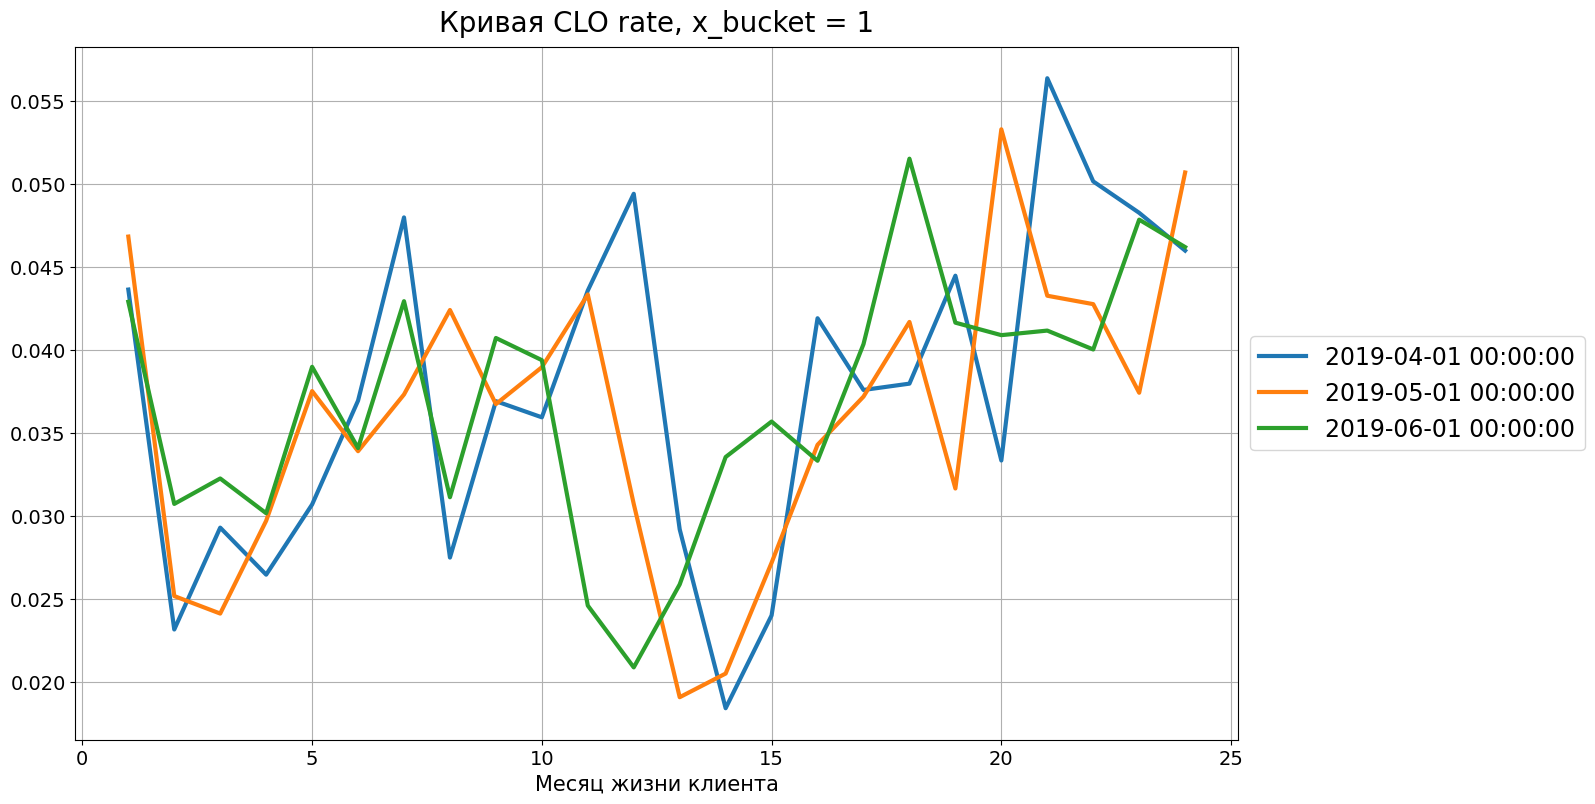

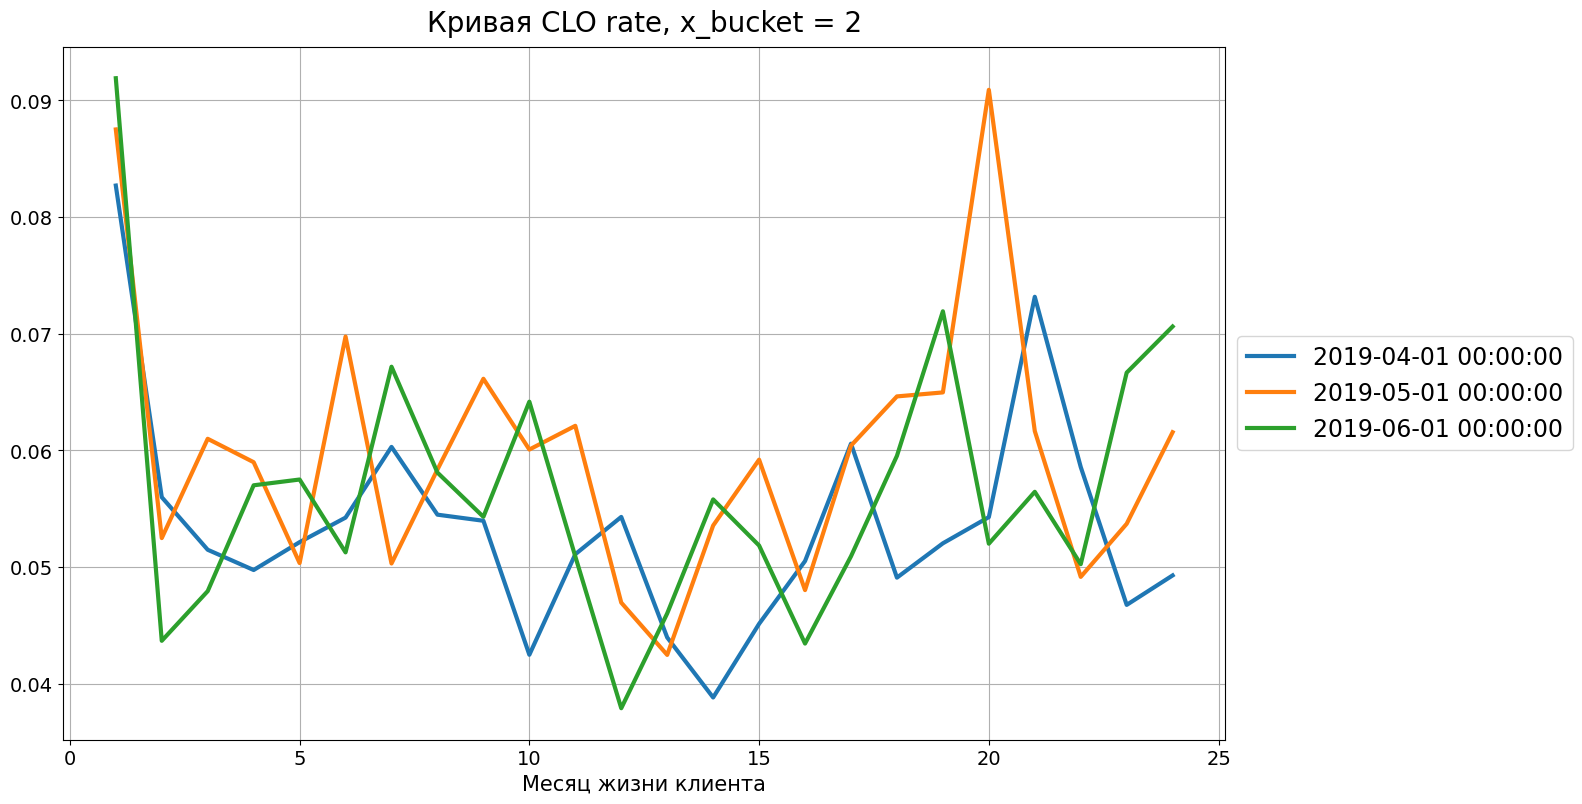

In [ ]:
gen_start= '2019-03-01'
gen_end = '2019-06-01'
for i in buckets:
    plot_clo_rate_by_generation_range(df, i, gen_start, gen_end)

2019-*05*-01 + 15 мясяцев странная точка на бакете 2

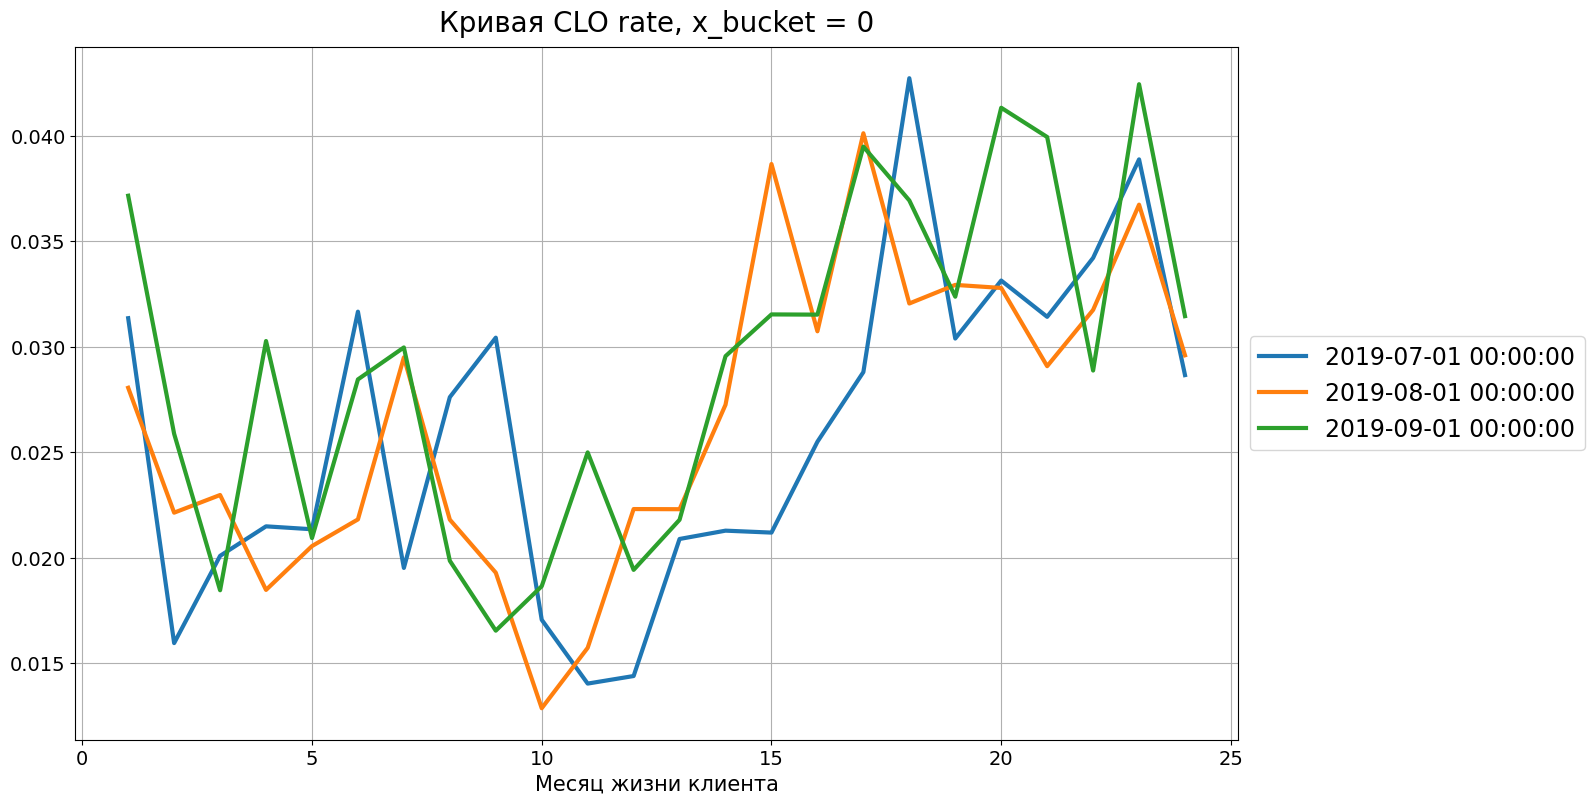

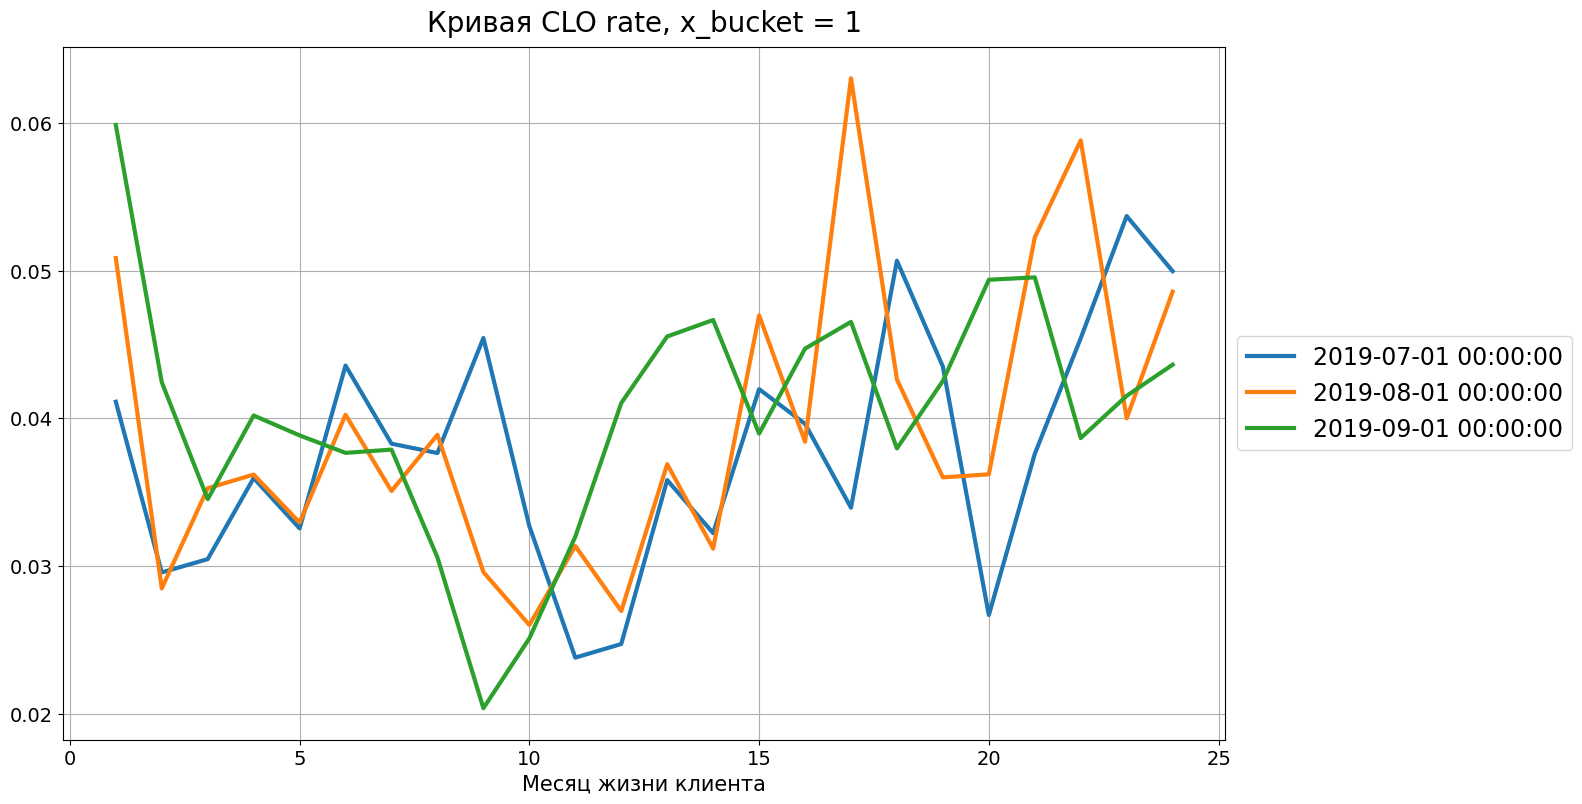

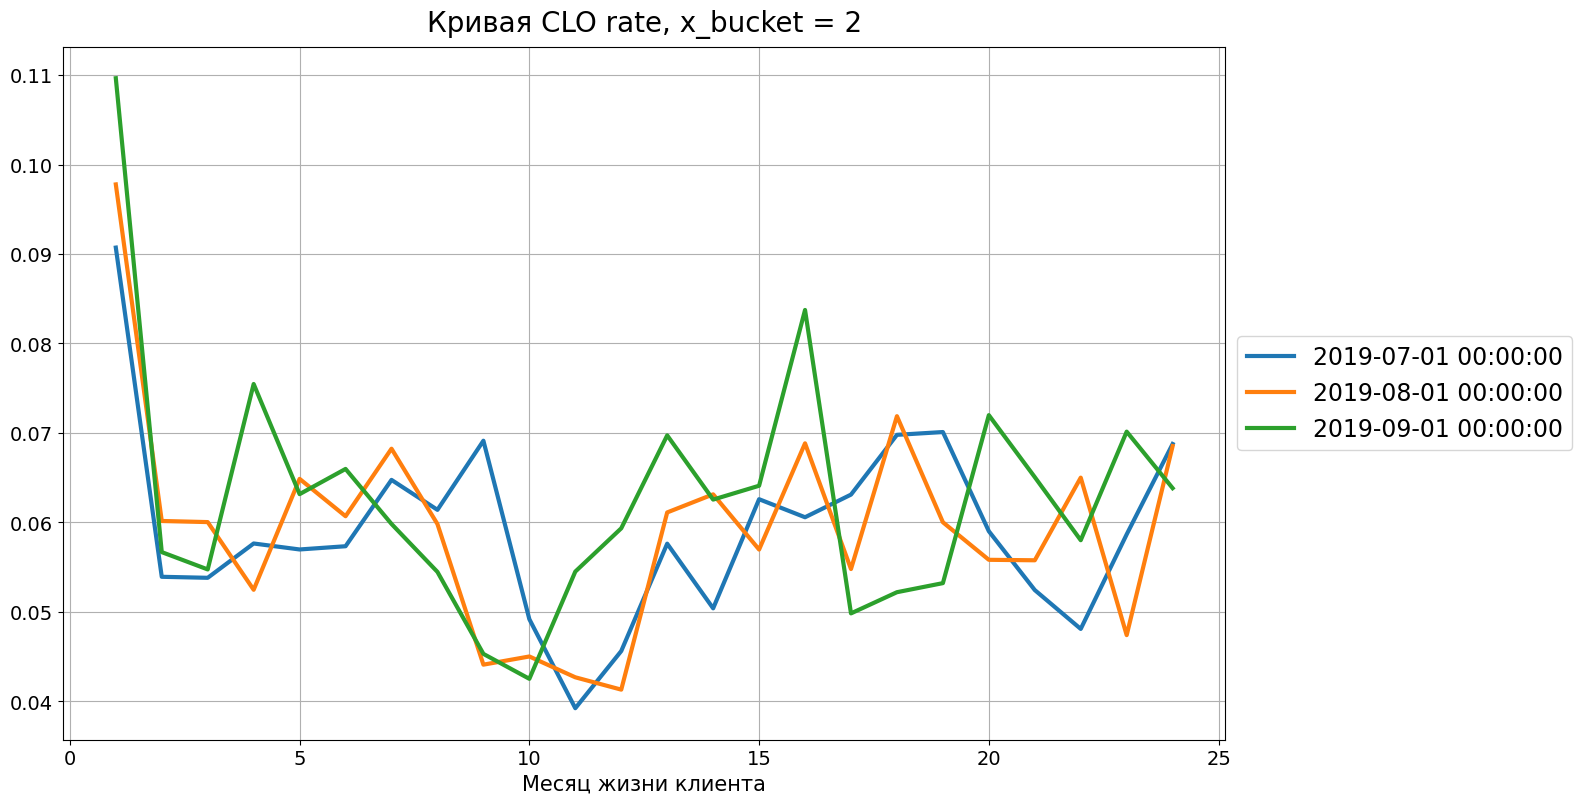

In [ ]:
gen_start= '2019-06-01'
gen_end = '2019-09-01'
for i in buckets:
    plot_clo_rate_by_generation_range(df, i, gen_start, gen_end)

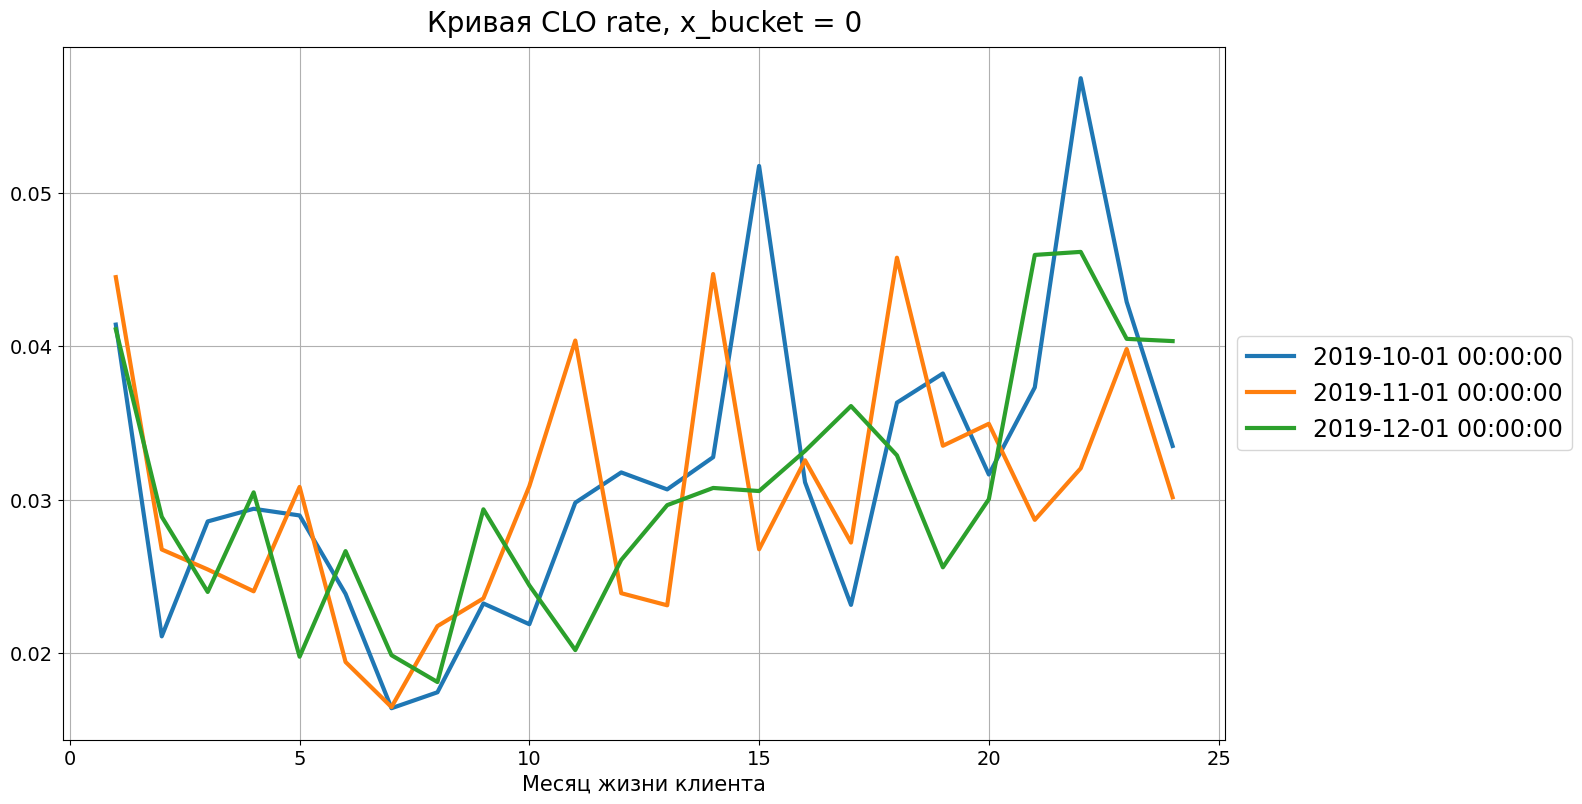

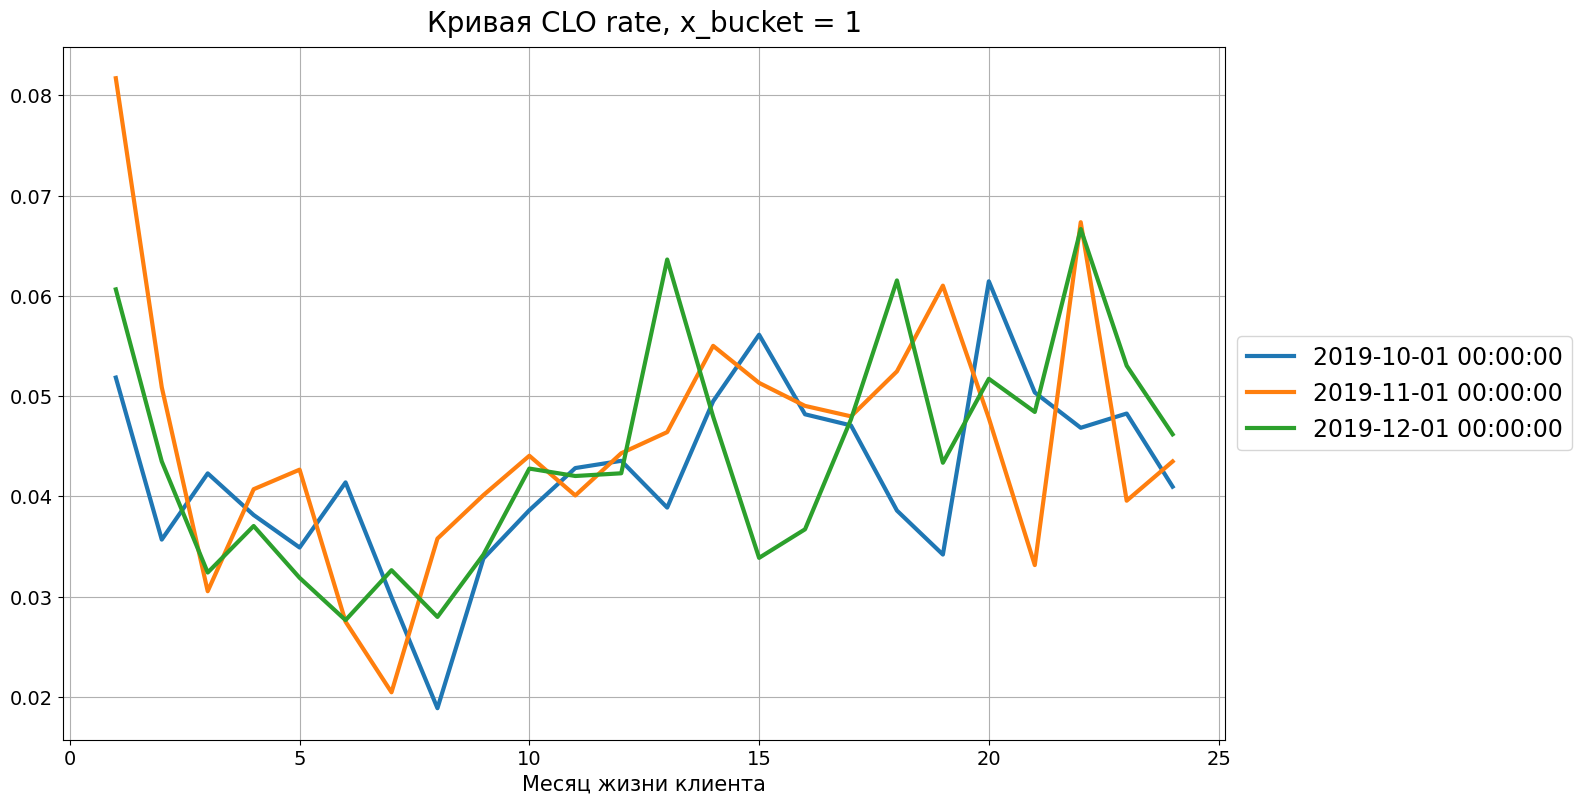

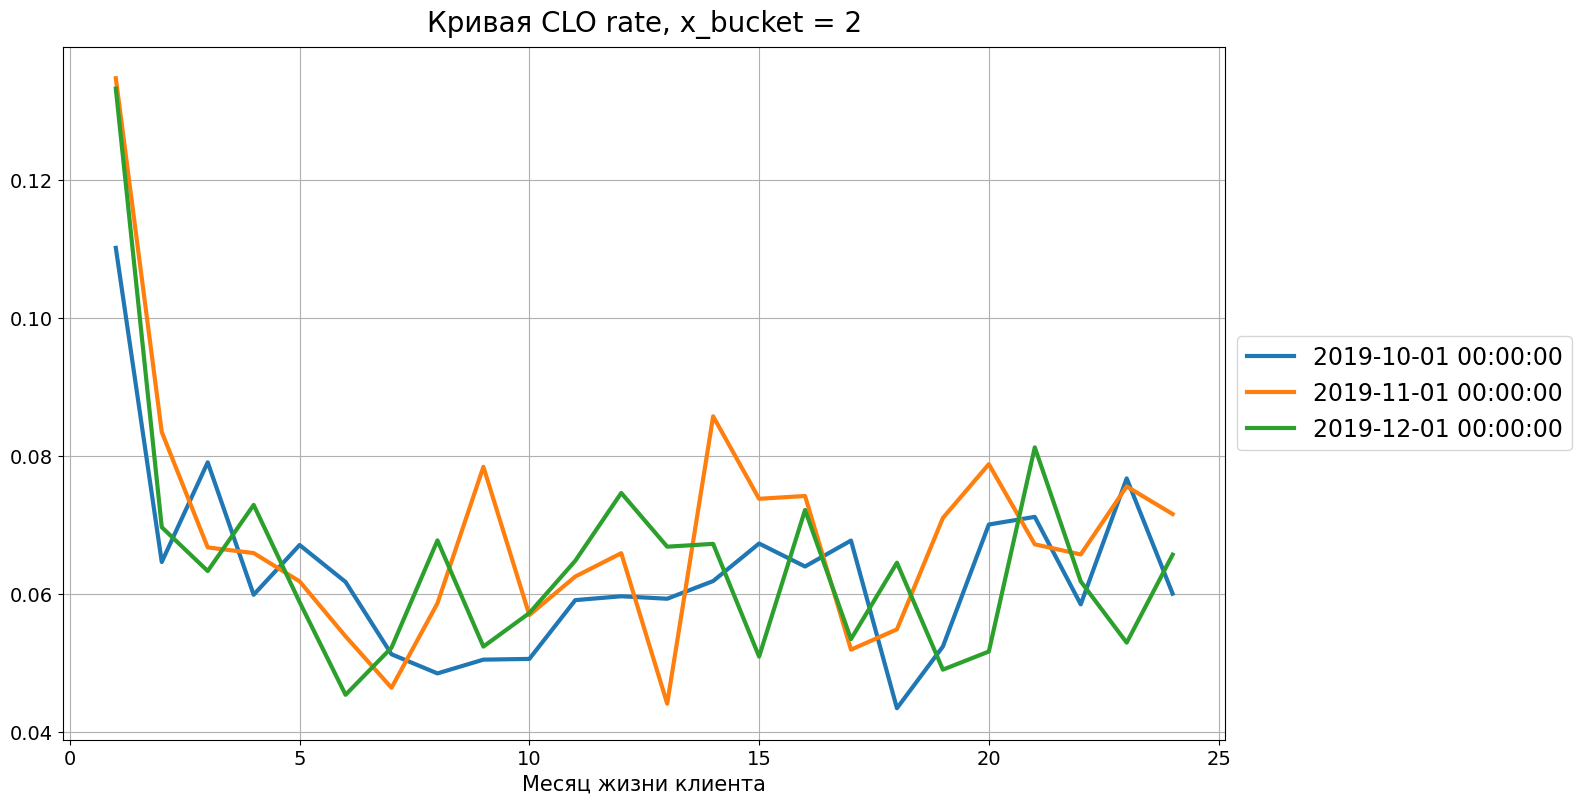

In [ ]:
gen_start= '2019-09-01'
gen_end = '2019-12-01'
for i in buckets:
    plot_clo_rate_by_generation_range(df, i, gen_start, gen_end)

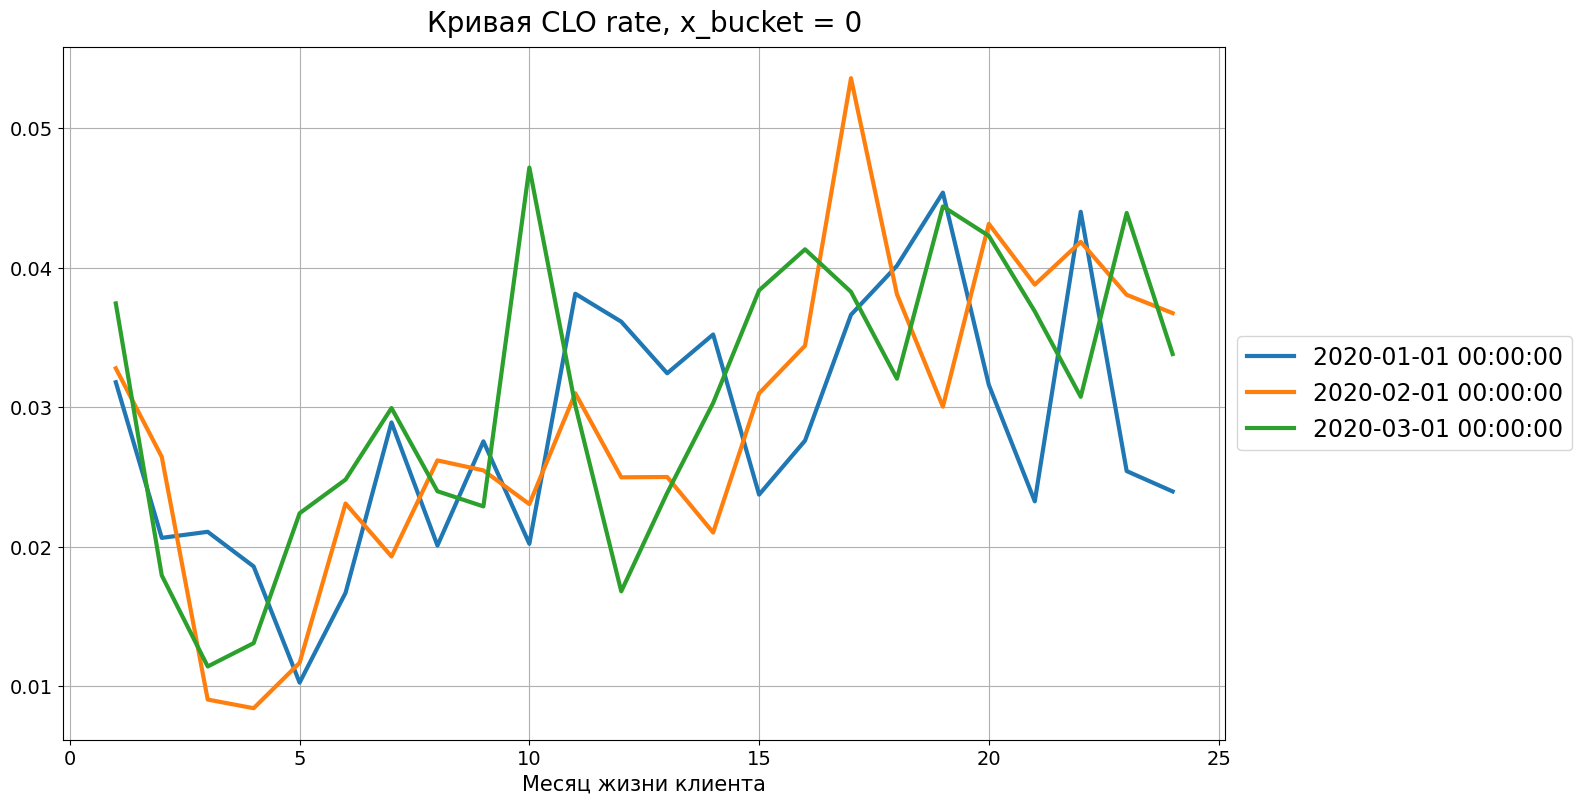

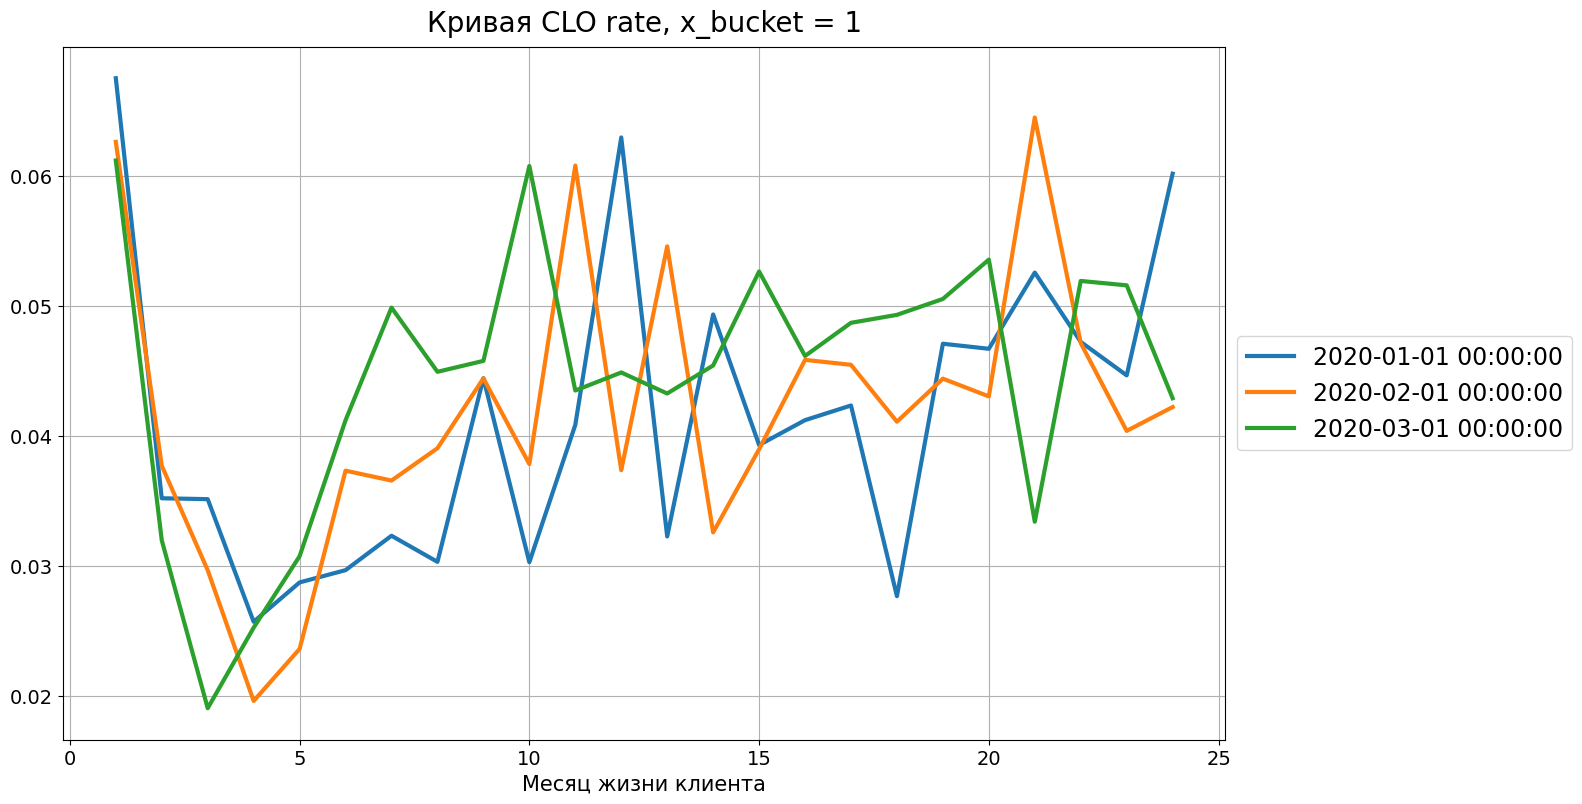

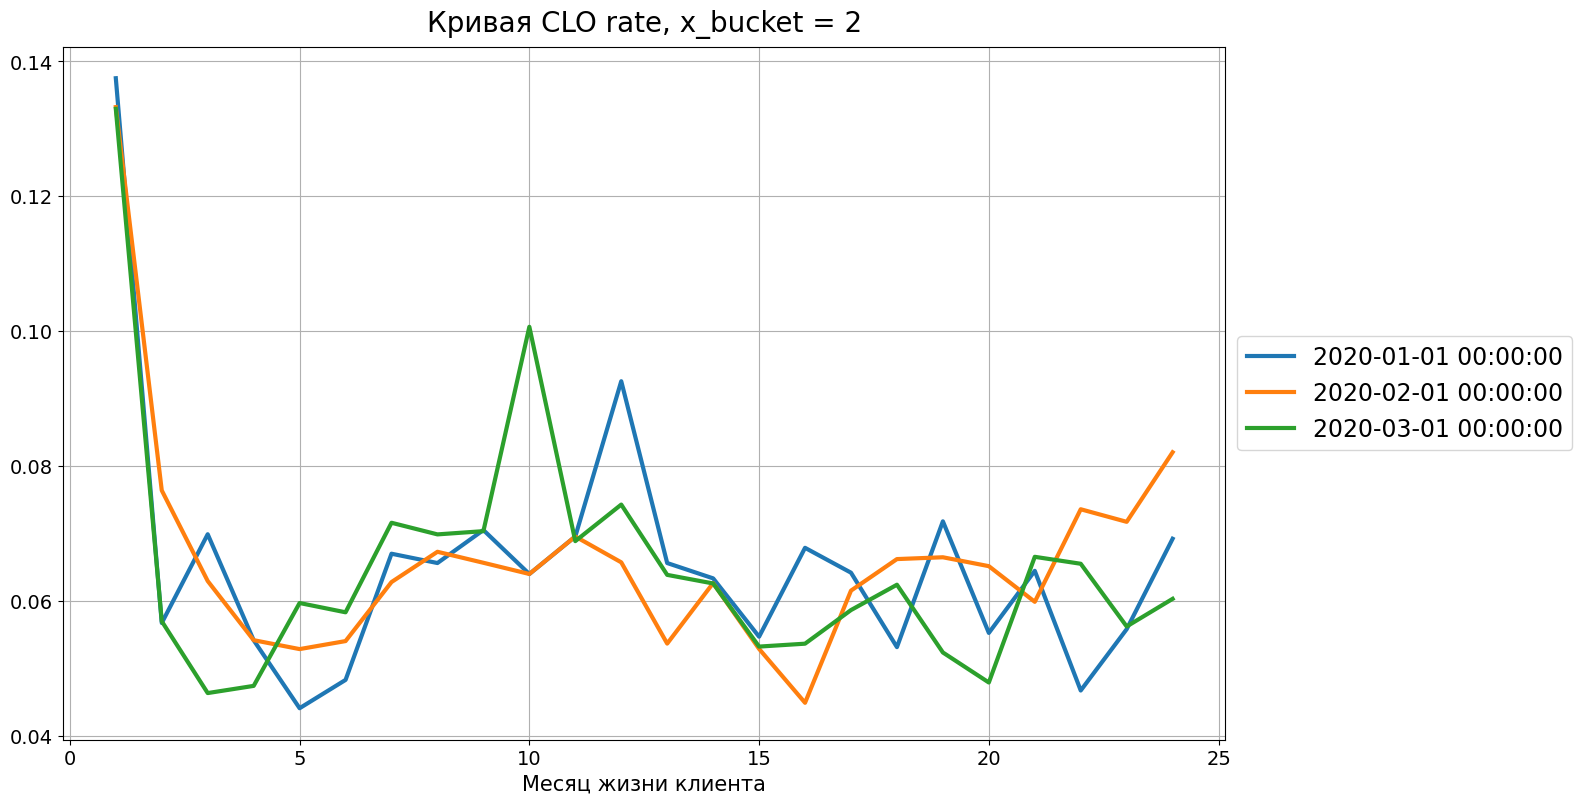

In [ ]:
gen_start= '2019-12-01'
gen_end = '2020-05-01'
for i in buckets:
    plot_clo_rate_by_generation_range(df, i, gen_start, gen_end)

#### Выводы: Данные бакетов 1 и 0 кажутся более шумными, предполагается что есть внешнее воздействие в точке 2020-08-01 - это 4 мясяца после объявления локдауна в россии.





### Макроэкономические воздействие (2 балла)

#### Вывод: внешнее воздействие произошло из-за пандемии и локдауна в 2020
#### В случае наличия внешнего влияния
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

In [ ]:
from pandas.tseries.offsets import DateOffset
def curve_build(data,
                feature,
                generation = 'generation_quart',
                statement_num = 'statement_num',
                group_label = '1'):

    """Вспомогательная функция для построения разложения в рамках одного бакета

    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """

    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0.5 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)],
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания

    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df,
                  generation = 'generation_month',
                  group = 'bucket',
                  statement_num = 'statement_num',
                  feature = 'feature',
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: DateOffset(months=x-1))

    month_dt = []
    for i in range(len(df_query[generation])):
      month_dt.append(timedelta[i] + df_query[generation][i])
    #print(timedelta[:5])
    #print(df_query[generation][:5])
    #print(month_dt[:5])
    df_query['month_dt'] = pd.Series(month_dt)# timedelta[0] + df_query[generation]
    #print(df_query['month_dt'][:5])
      # Формируем список бакетов

    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))

        # Строим разложение для одного бакета
        res = curve_build(df_temp,
                          feature = feature,
                          generation = generation,
                          statement_num = statement_num,
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i+=1

    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }
    return res_multiple

In [ ]:
# Подготавливаем данные
df_ratio = df.groupby(["x_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({"clo_flg":np.sum, "prev_act_flg":np.sum, "prev_clo_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"clo_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt',"prev_clo_flg":'prev_clo_cnt',  "user_id":"cnt"}))\
        .eval('clo_rate = (clo_cnt-prev_clo_cnt) / prev_act_cnt', inplace=False)


# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(df_ratio,
                       generation = 'gen_month_dt',
                       group = 'x_bucket',
                       statement_num = 'statement_num',
                       feature = 'clo_rate')

x_bucket = 0
Initial 15.357556
0  0.072406
1  0.031210
2  0.027401
3  0.024418
4  0.021690
5  0.019101
6  0.010634
7  0.009730
8  0.009389
9  0.009240
10  0.009165
11  0.009057
12  0.009032
13  0.009011
14  0.008877
15  0.008847
16  0.008753
17  0.008721
18  0.008504
19  0.008469
20  0.008443
21  0.008310
22  0.008280
23  0.008215
24  0.008212
25  0.008210
26  0.008209
27  0.008203
28  0.008203
29  0.008202
30  0.008202
31  0.008202
32  0.008202
33  0.008202
34  0.008202
35  0.008202
x_bucket = 1
Initial 13.733869
36  0.145197
37  0.058355
38  0.046978
39  0.038102
40  0.030936
41  0.025421
42  0.021426
43  0.018679
44  0.016864
45  0.015697
46  0.014961
47  0.014504
48  0.014224
49  0.014052
50  0.013948
51  0.013886
52  0.013848
53  0.013825
54  0.013812
55  0.013804
56  0.013799
57  0.013796
58  0.013794
59  0.013793
60  0.013792
61  0.013792
62  0.013792
63  0.013792
64  0.013792
65  0.013792
66  0.013792
67  0.013791
68  0.013791
x_bucket = 2
Initial 11.107050
69  0.328346
70  0.1

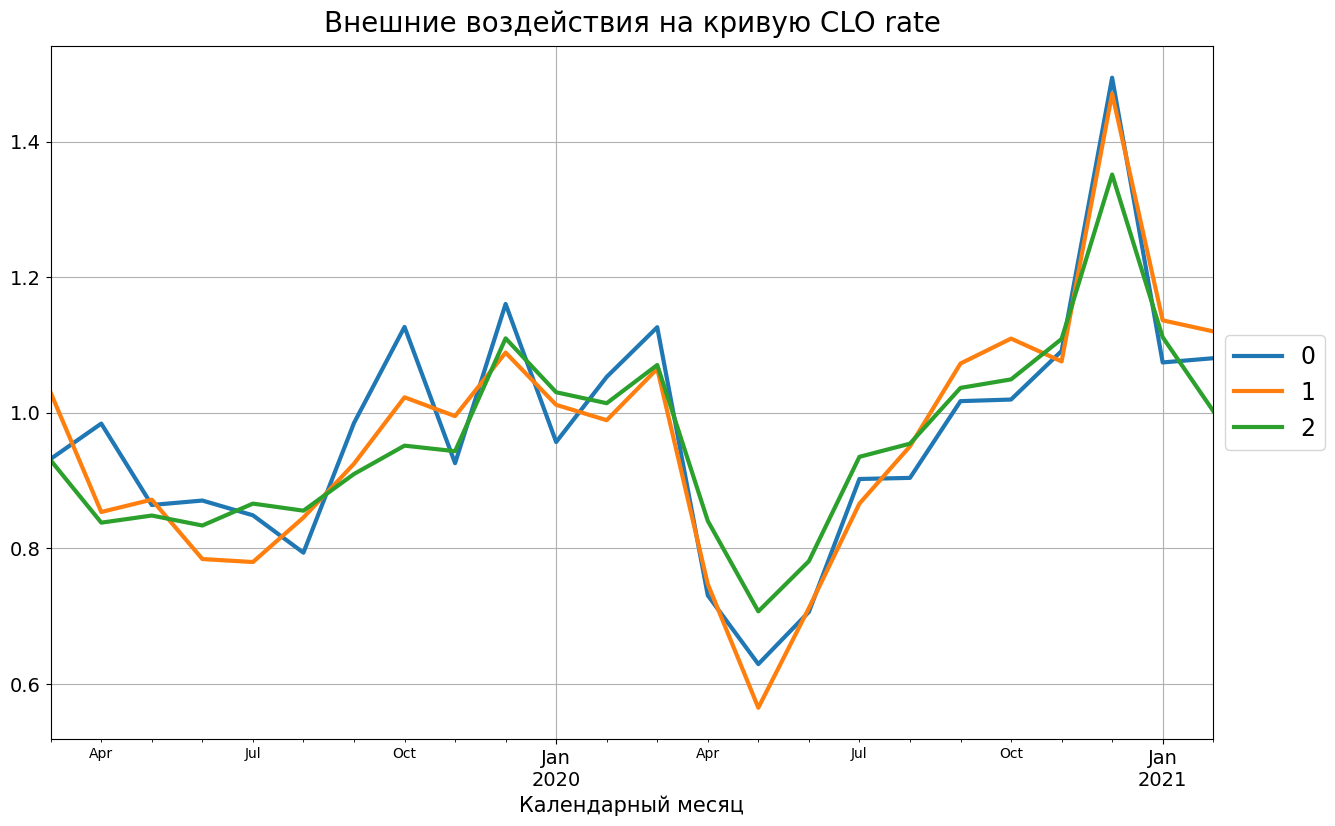

In [ ]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

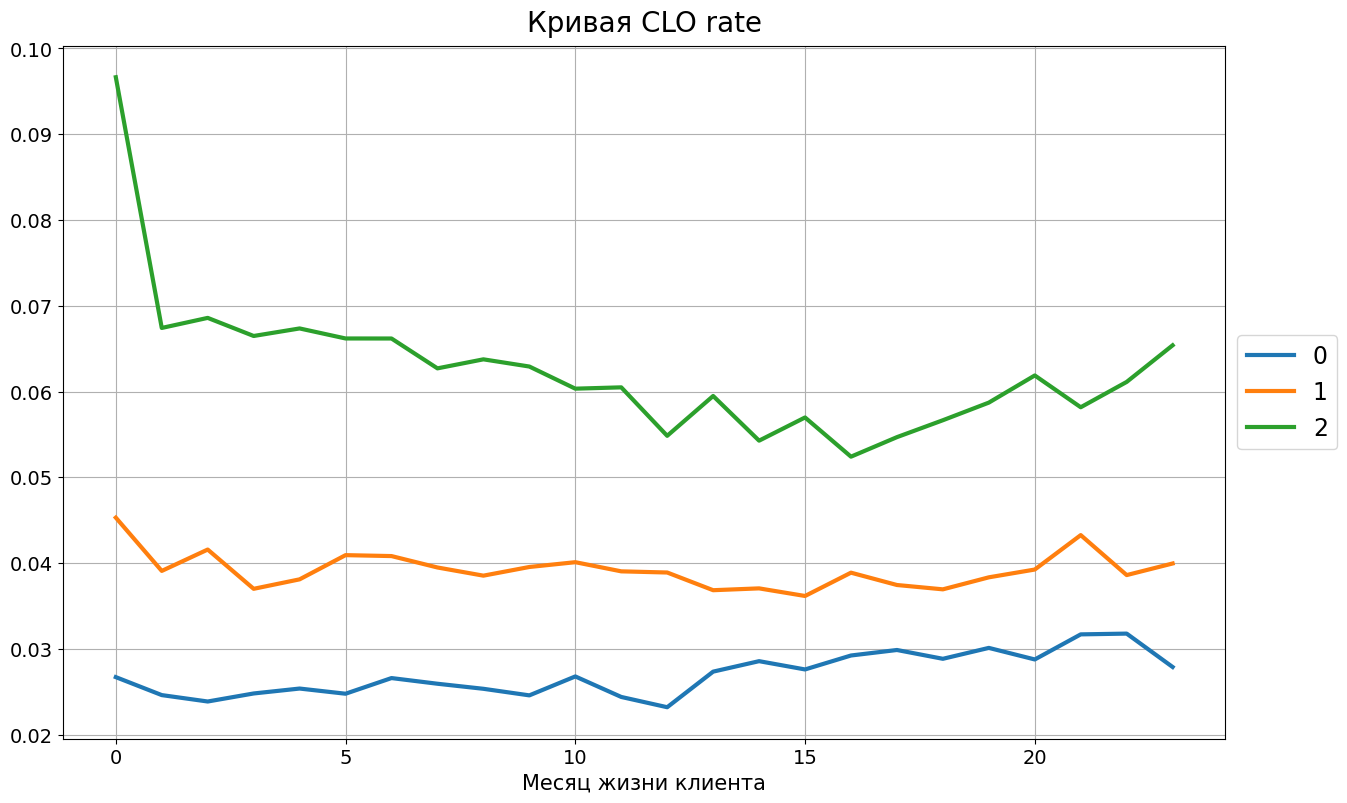

In [ ]:
res['maturation_data'].drop(labels=['statement_num'],axis=1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Среднее по бакетам (0.5 баллов)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

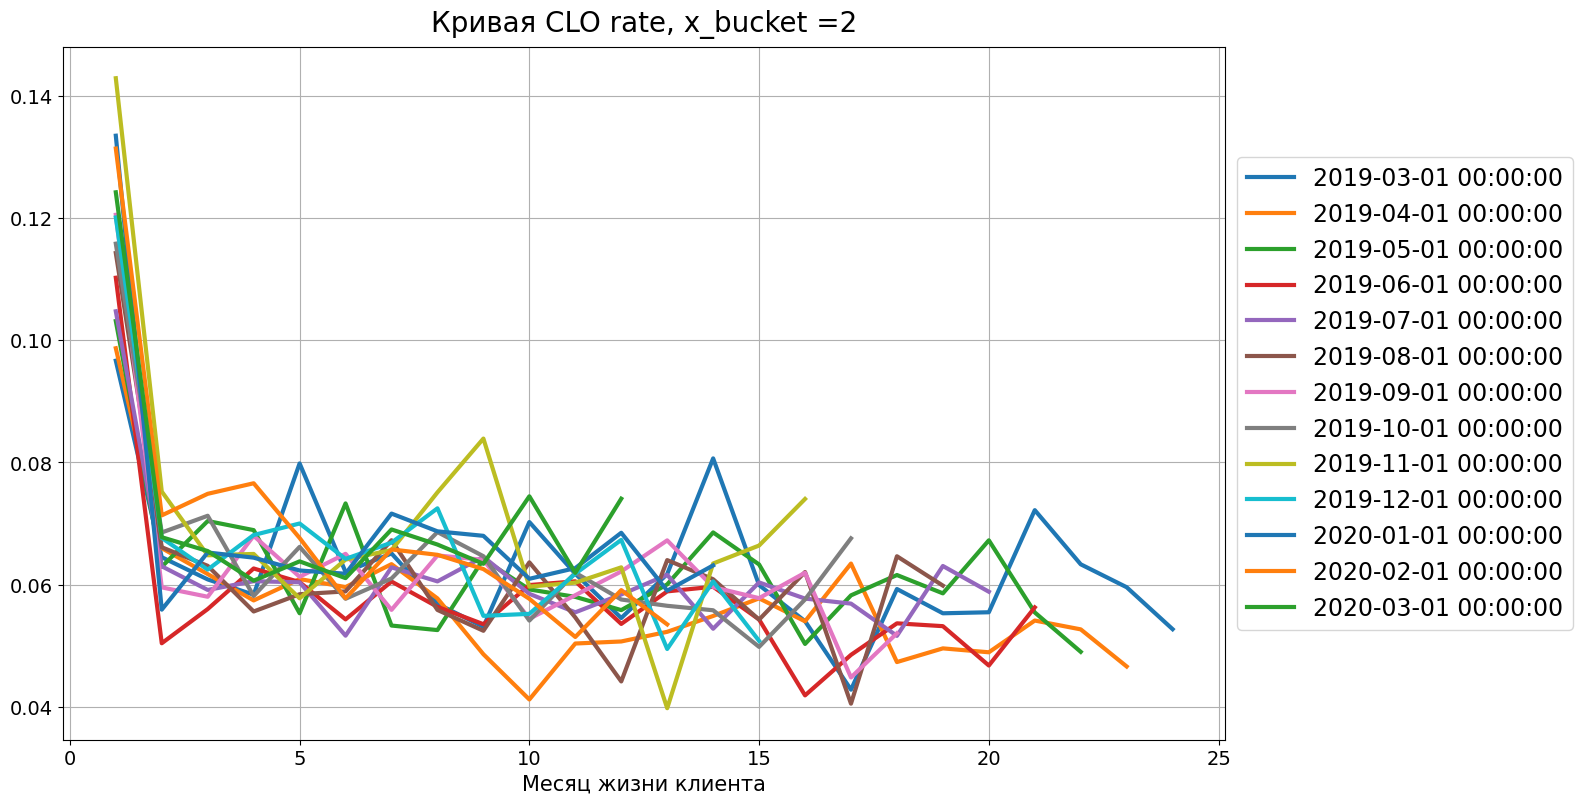

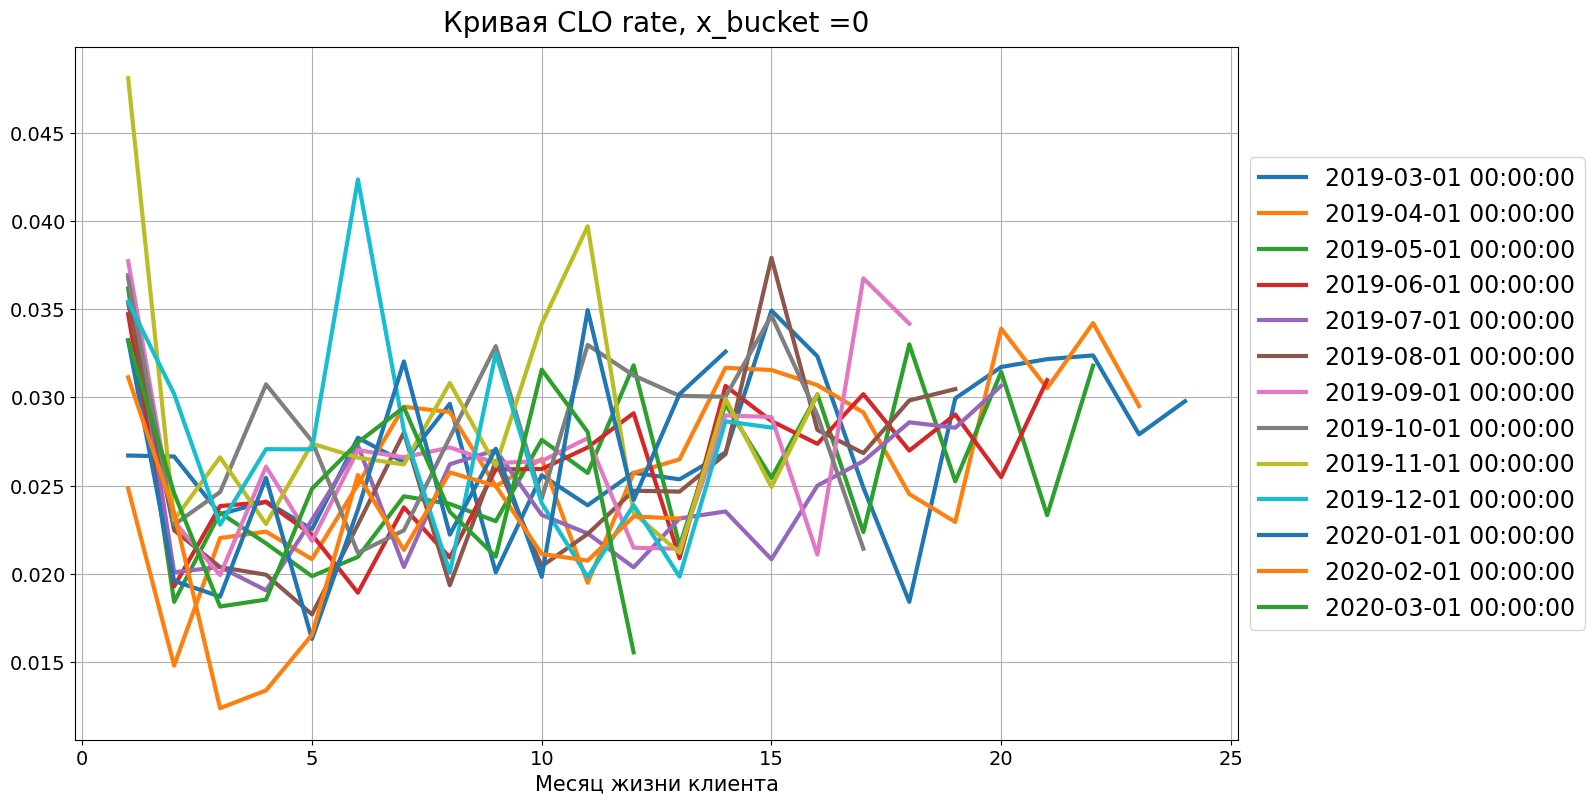

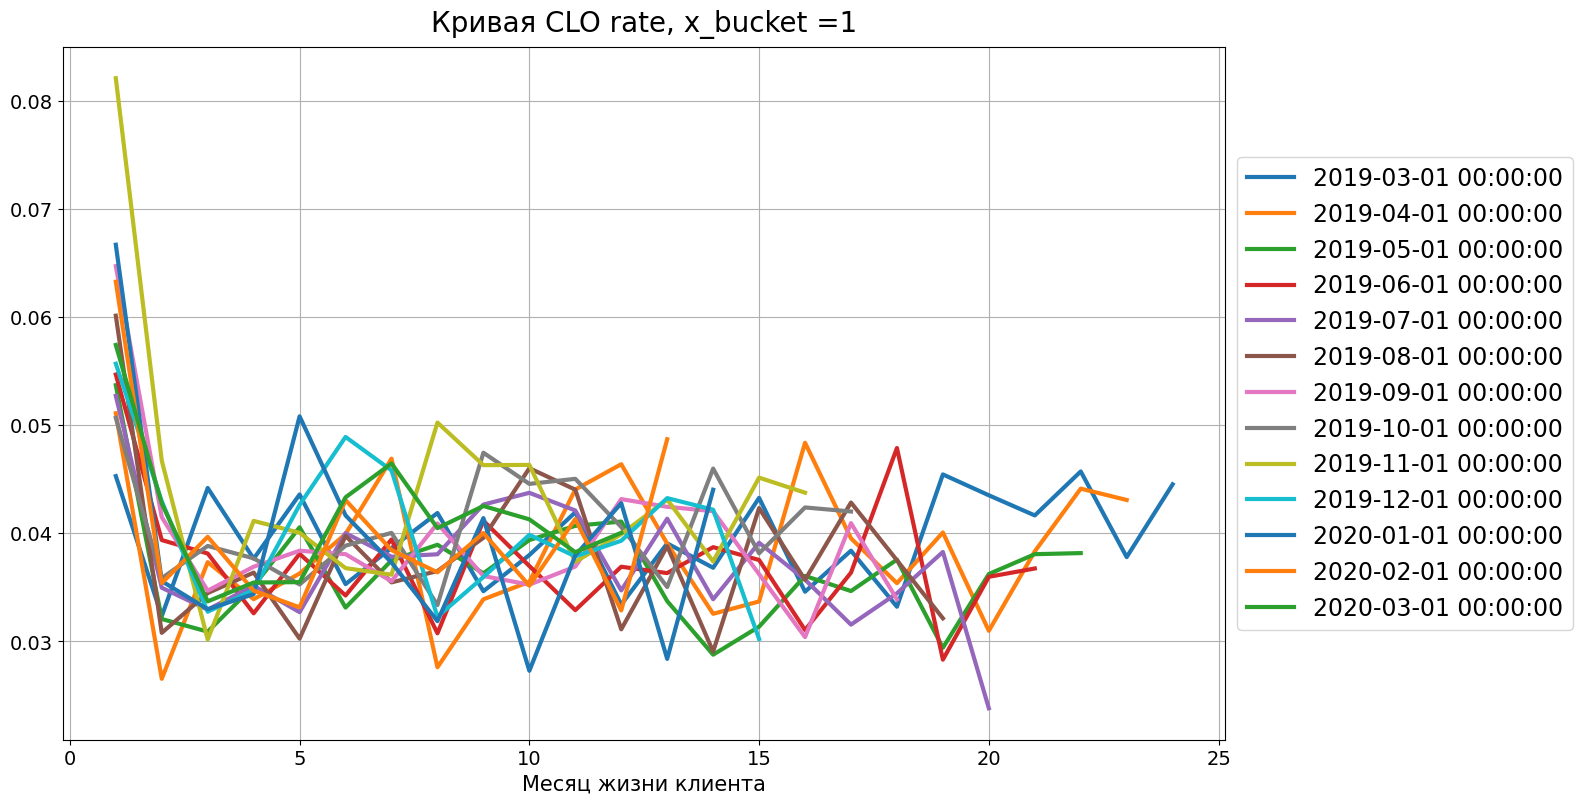

In [ ]:
# Считаем среднее

def_rate_mean = res['fitted_data'].groupby([ 'x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(x_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
#     (dlq_ratio_mean.query('pd_bucket == ' + str(pd_bucket))['Среднее']
#              .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая CLO rate, x_bucket =" + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_clo_rate_mean(i)

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res

def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])):
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

### Сглаживание средних кривых (0.5 баллов)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

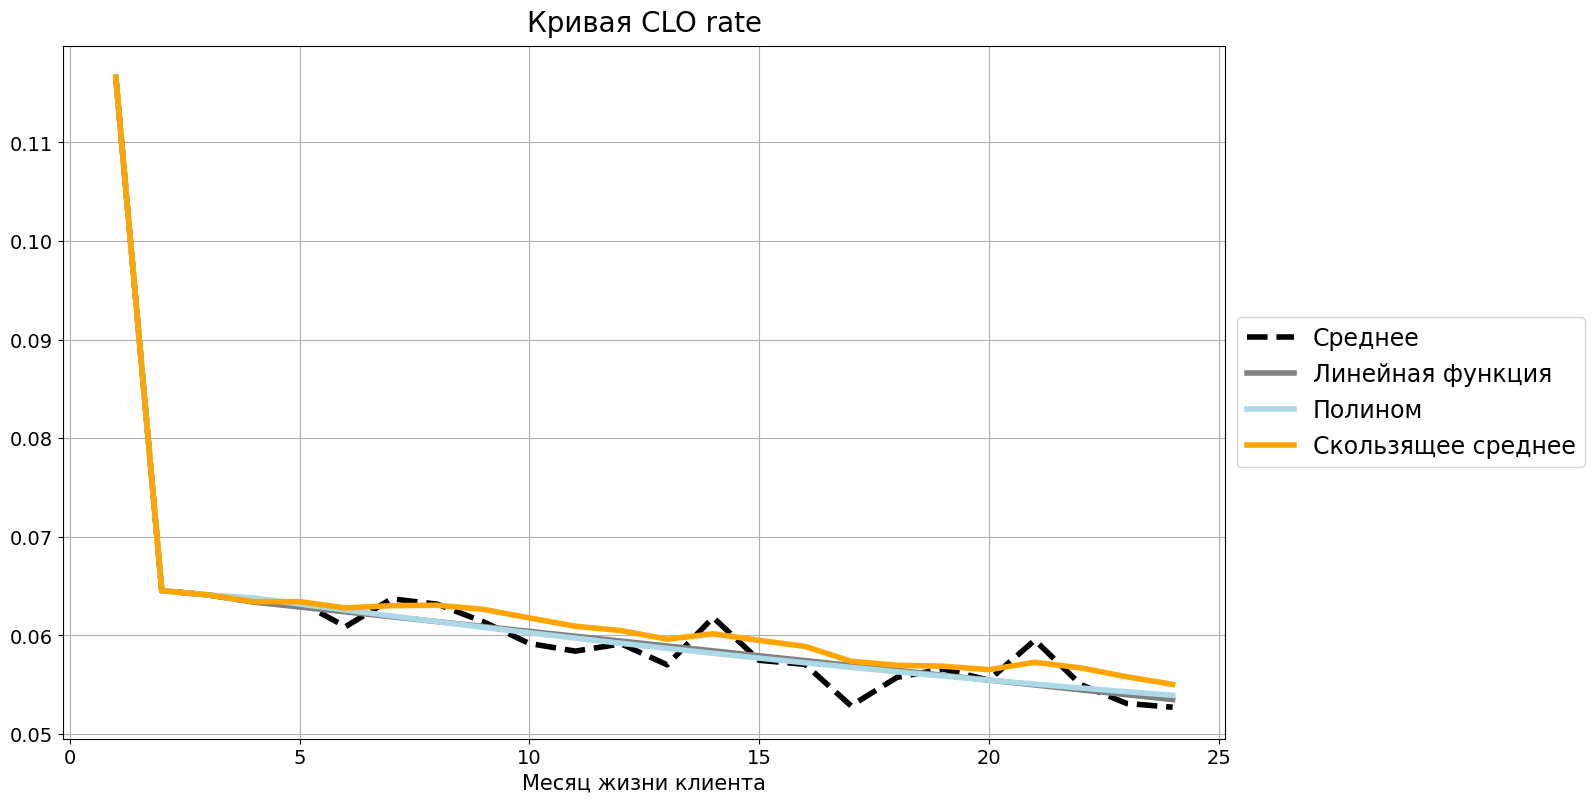

In [ ]:
df_linear = def_rate_mean.query('x_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4,24,2)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: выбрал полином потому что он не такой шумный как среднее и лучшее апроксимирует чем скользящее среднее. Хотя разница между этими функциями незначительная

### Отрисуй сглаженные кривые по всем трем бакетам PD

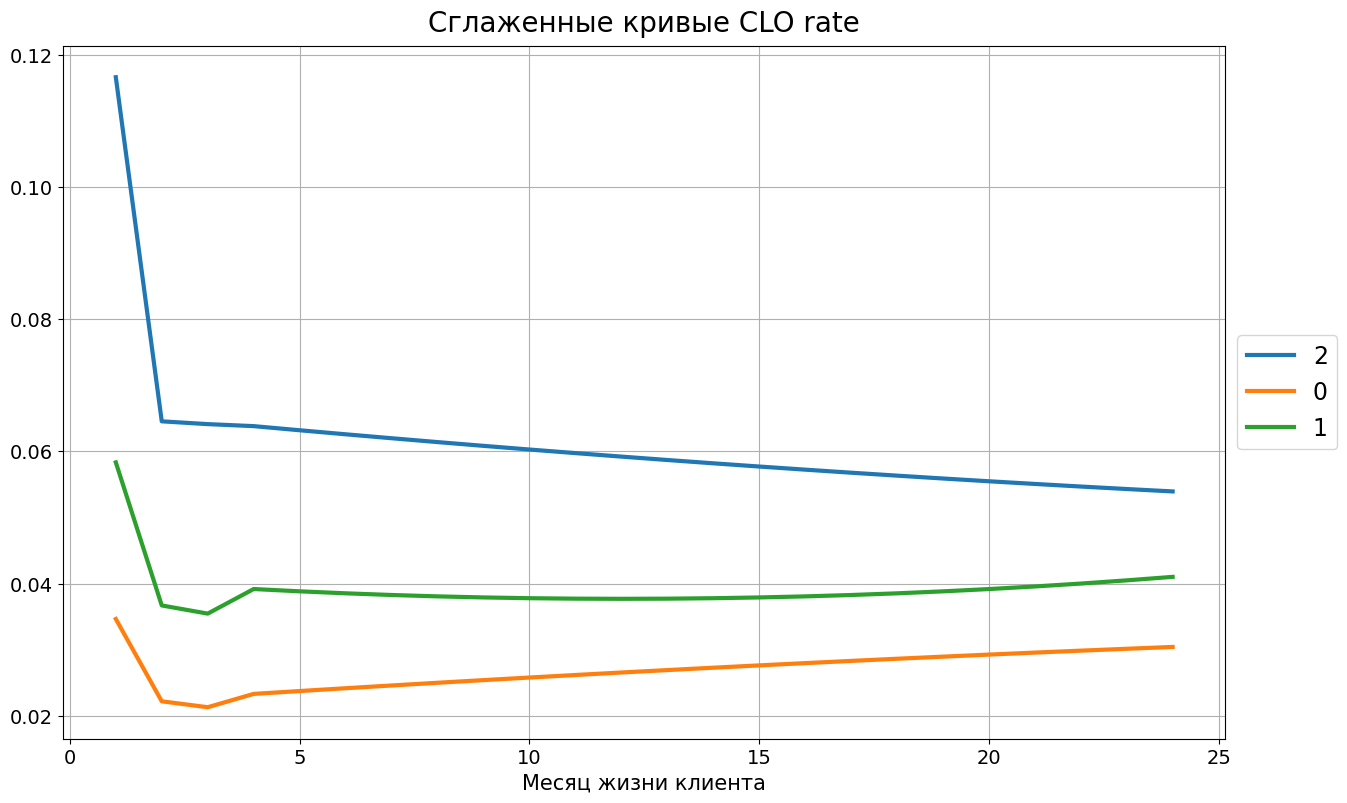

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = def_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4,24,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
df_smooth_result.to_csv('clo_rate.csv')